<a href="https://colab.research.google.com/github/leandroaguazaco/data_science_portfolio/blob/main/Projects/04-Churn_Telco_Analysis/04_Churn_Telco_Analysis_01_Preprocessing_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"> 4 - CHURN TELCO ANALYSIS </h1>
<h2 align="center"> 4.1 - Preprocessing </h2>

<div align="center">

  <img alt="Static Badge" src="https://img.shields.io/badge/active_project-true-blue">

  <img alt="Static Badge" src="https://img.shields.io/badge/status-in progress-green">

</div>  

<object
data="https://img.shields.io/badge/contact-Felipe_Leandro_Aguazaco-blue?style=flat&link=https%3A%2F%2Fwww.linkedin.com%2Fin%2Ffelipe-leandro-aguazaco%2F">
</object>

## a. Project summary

The aim of this project is to analyze and predict customer churn in the telco industry. The information pertains to client behavior, including in-call, out-call, and internet service consumption. There is a variable called 'Churn' that determines whether a customer churned within two weeks after canceling services. The information summarizes eight weeks of data for each telco line or client.

<h3 align="center"> <font color='orange'>NOTE: The project is distributed across multiple sections, separated into notebook files, in the following way:</font> </h3>



> <font color='gray'> 4.1 - Preprocessig data: load, join and clean data, and Exploratory data analysis, EDA.</font> ✍ ▶ Current section

4.2 - Pre-modeling: predict customer churn based on PyCaret library.

4.3 - Modeling: predict customer churn based on sklearn pipelines.

4.4 - Analyzing and explaining predictions.

4.5 - Detecting vulneabilities in final machine learnig model.

4.6 - Model deployment with Streamlit.

## b. Install libraries

Additional libraries such as pandas, numpy, matplotlib, seaborn, and others are already installed in the Colab environment.

In [1]:
%%capture
# Preprocessing
!pip install pandas
!pip install polars
!pip install xlsx2csv
!pip install pyjanitor # Clean DataFrame
!pip install colorama
!pip install adjustText
!pip install rpy2==3.5.1 # Use R

# EDA
!pip install -U matplotlib #!pip install matplotlib==3.3
!pip install seaborn
!pip install missingno
!pip install pyod # Python library for detecting anomalies in multivariate data.
!pip install prince # Python library for multivariate exploratory data analysis in Python
!pip install -U ydata-profiling

## c. Import libraries

In [235]:
%%capture
# c.1 Python Utilies
import pandas as pd
import polars as pl
import numpy as np
import functools
import glob
import math
from scipy.stats import spearmanr
import scipy.stats as stats
import warnings
from janitor import clean_names, remove_empty
import rpy2
import shutil
from google.colab import drive
import os

# c.2 Visulization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from colorama import Fore, Style

# c.3 EDA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from ydata_profiling import ProfileReport
import prince # MCA
import missingno as msno
from pyod.models.ecod import ECOD
from pyod.models.iforest import IForest
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
# c.3 Setups
%matplotlib inline
plt.style.use("ggplot")
warnings.simplefilter("ignore")

## d. Custom functions

### d.1 - Load csv files

In [110]:
def custom_readcsv(filepath: str = None) -> pd.DataFrame:
  """
  Summary:
    Function to read a csv files, set SUBSCRIBER_ID as index column and drop unncessary column.
  Parameters:
    file(str, default = None): path to your file of interest.
  Return
    pandas DataFrame.
  """
  df = pd.read_csv(filepath_or_buffer = filepath,
                   sep = "|",
                   index_col = "SUBSCRIBER_ID",
                   parse_dates = True,
                   decimal = ",",
                   encoding = "utf-8") \
         .pipe(lambda x: x.drop([x.columns[0]], axis = 1)) \
         .pipe(clean_names)

  return df

### d.2 - Type conversions

In [89]:
# d.2.1 dtypes conversion and memory reduce function.
def dtype_conversion(df: pd.DataFrame = None, verbose: bool = True)-> pd.DataFrame:
    """
    Summary:
      Function to dtypes conversion and save reduce memory usage; takes a DataFrame as argument, returns DataFrame.
      For more details, visit: https://towardsdatascience.com/how-to-work-with-million-row-datasets-like-a-pro-76fb5c381cdd.
      The modifications include type casting for numerical and object variables.
    Parameters:
      df (pandas.DataFrame): DataFrame containing information.
      verbose (bool, default = True): If true, display results (conversions and warnings)
    Returns:
      pandas.DataFrame: original DataFrame with dtypes conversions
      Plot original dtypes status, variable warning due high cardinality, save memory usage, final dtypes status.
    """
    # 0- Original dtypes
    # print(Fore.GREEN + "Input dtypes" + Style.RESET_ALL)
    # print(df.dtypes)
    # print("\n")
    print(Fore.RED + "High Cardinality, categorical features with levels > 15" + Style.RESET_ALL)

    # 1- Original memory_usage in MB
    start_mem = df.memory_usage().sum() / 1024 ** 2

    # 2- Numerical Types
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int": # First 3 characters
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max):
                    df[col] = df[col].astype(np.float32)
                #elif (c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max):
                #    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    # 3- Categorical Types
    high_card_vars = 0
    for col in df.select_dtypes(exclude = ["int8", "int16", "int32", "int64", "float16", "float32", "float64", "datetime64[ns]"]):
        categories = list(df[col].unique())
        cat_len = len(categories)
        if cat_len >= 2 and cat_len < 15:
           df[col] = df[col].astype("category")
        else:
          high_card_vars =+ 1
          # Print hight cardinality variables, amount of levels and a sample of 50 firts categories
          print(f"Look at: {Fore.RED + col + Style.RESET_ALL}, {cat_len} levels = {categories[:50]}")
    if high_card_vars == 0:
      print(Fore.GREEN + "None" + Style.RESET_ALL)
    else:
      pass

    # 4- Final memory_usage in MB
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print("\n")
        print(f"{Fore.RED}Initial memory usage: {start_mem:.2f} MB{Style.RESET_ALL}")
        print(f"{Fore.BLUE}Memory usage decreased to {end_mem:.2f} MB ({ 100 * (start_mem - end_mem) / start_mem:.1f}% reduction){Style.RESET_ALL}")
        #print("\n")
        #print(Fore.GREEN + "Output dtypes" + Style.RESET_ALL)
        #print(df.dtypes)
        print("\n")

    # 5. Feature types
    print(Fore.GREEN + "Variable types" + Style.RESET_ALL)
    numerical_vars = len(df.select_dtypes(include = ["number"]).columns)
    categorical_vars = len(df.select_dtypes(include = ["category", "object"]).columns)
    datetime_vars = len(df.select_dtypes(include = ["datetime64[ns]"]).columns)
    print(f"Numerical Features: {numerical_vars}")
    print(f"Categorical Features: {categorical_vars}")
    print(f"Datetime Features: {datetime_vars}")

    return df

### d.3 - Summary statistics

In [90]:
# d.3.1 Summary statistics function
def summary_stats(df: pd.DataFrame = None):
  """
  Summary:
    Using python built functions to summary a DataFrame: DataFrame Shape, memory usage, general information.
    Numerical statistics: count, mean, median, min max, std, quartiles, skewness and kurtosis.
    Categorical statistics: count, unique, top frequency.
    Datetime statistics: count, unique, top, frequency, first, last.
  Parameters:
    df (pandas.DataFrame): DataFrame.
  Return:
    Shows multiple levels of summary statistics.
  """
  # DataFrame Shape
  print(Fore.GREEN + "DataFrame Shape" + Style.RESET_ALL)
  print(f"Rows = {df.shape[0]}, Columns = {df.shape[1]}")
  print("\n")

  # DataFrame Shape Memory usage
  print(Fore.GREEN + "DataFrame Memory usage" + Style.RESET_ALL)
  print(f"Memory usage = {df.memory_usage().sum() / 1024 ** 2:.2f} MB")
  print("\n")

  # General Information
  print(Fore.GREEN + "General Information" + Style.RESET_ALL)
  print(df.info())
  print("\n")

  # Summary Statistics - Datetime Variables
  print(Fore.GREEN + "Summary Statistics - Datetime Variables" + Style.RESET_ALL)
  if len(df.select_dtypes(include = ["datetime64[ns]"]).columns) == 0:
    print("None")
  else:
    print(df.describe(include = ["datetime64[ns]"]).T.to_markdown())
  print("\n")

  # Summary Statistics - Numerical Variables
  print(Fore.GREEN + "Summary Statistics - Numerical Variables" + Style.RESET_ALL)
  if len(df.select_dtypes(exclude = ["object", "category", "datetime64[ns]"]).columns) == 0:
    print("None")
  else:
    print(pd.DataFrame(df.describe(exclude = ["object", "category", "datetime64[ns]"]).T) \
            .merge(pd.DataFrame(df.skew(), columns = ["skewness"]), how = "inner", left_index = True, right_index = True) \
            .merge(pd.DataFrame(df.kurtosis(), columns = ["kurtosis"]), how = "inner", left_index = True, right_index = True) \
            .round(3) \
            .to_markdown())
  print("\n")

  # Summary Statistics - Categorical Variables
  print(Fore.GREEN + "Summary Statistics - Categorical Variables" + Style.RESET_ALL)
  if len(df.select_dtypes(exclude = ["number", "datetime64[ns]"]).columns) == 0:
    print("None")
  else:
    df_sum_cat = df.describe(exclude = ["number", "datetime64[ns]"]).T
    df_sum_cat["prop_top"] = (df_sum_cat["freq"] / df_sum_cat["count"]).map(lambda x: round(x, 2))
    print(df_sum_cat.to_markdown())

### d.4 - Numerical distributions

In [201]:
# d.4.1 numerical distributions: grouped histrograms plot
def distrib_plots_seaborn(df: pd.DataFrame = None, cat: str = None,
                          stat: str = "count", cols: int = 4, binwidth = None,
                          kde: bool = False, y_logscale: bool = False, figsize = (10, 8)):
  """
  Summary:
    Function to create grouped plots of distributions based on histograms, using the seaborn plotting engine.
  Parameters:
    df (pandas.DataFrame): Dataset in pandas format.
    cat (string, default = None): Huening histograms by categorical variable.
    stat (string, default = count): Aggregate statistic to compute in each bin.
    cols (int, default = 4): grid' columns.
    binwidth (default = none): Width of each bin.
    kde (bool, default = False): Compute a kernel density estimate to smooth the distribution.
    y_logscale = Set y axis scale to log 10.
    figsize (tuple, default = (10, 8)): figure's size
  Returns:
    Grouped plots of histograms.
  """

  # 0. Numerical variables
  vars = list(df.select_dtypes(include = "number").columns)
  number_var = len(vars)

  # 1. Number of rows in plot matrix
  rows = math.ceil(number_var / cols)

  # 2. Number of columns in plot matrix, by default 2 columns
  cols = cols

  # 3. Create a figure and a set of subplots
  fig, axs = plt.subplots(nrows = rows,
                          ncols = cols,
                          figsize = figsize)
  axs = axs.flatten()

  # 4. Set log scale in y axis
  if y_logscale:
    log_scale = [False, 10]
  else:
    log_scale = False

  # 5. Create plots
  sns.set_palette(palette = "viridis") # Viridis pallete
  for i, var in enumerate(vars):
    # Figure
    sns.histplot(data = df,
                 x = var,
                 hue = cat,
                 ax = axs[i],
                 stat = stat,
                 kde = kde,
                 # weights = 'weights',
                 #discrete = True,
                 common_norm = False,
                 multiple = "stack",
                 binwidth = binwidth,
                 log_scale = log_scale,
                 edgecolor = "black")
    axs[i].set_xlabel(var)

    # Legend
    if cat == None:
    # Not insert legend
      pass
    else:
    # Insert legend
      sns.move_legend(axs[i],
                      "best",
                      fontsize = 'x-small',
                      edgecolor = "gray",
                      # bbox_to_anchor = (.3, 1),
                      # ncol = 3,
                      # title = None,
                      title_fontsize = 'medium',
                      frameon = True)

  # plt.title('Distributions of Numerical Variables')
  fig.tight_layout() # To enhance visualization

  plt.show()

### d.5 - Categorical distributions

In [92]:
# d.5.1 Categorical distributions
def barplots_seaborn(df: pd.DataFrame = None, cat: str = None, stat: str = "count", cols = 3, figsize: tuple = (12, 25)):
  """
  Summary:
    Function to create grouped plots of distributions based on histograms, using the seaborn plotting engine.
  Parameters:
    df (pandas.DataFrame): Dataset in pandas format.
    cat (string, default = None): Huening histograms by categorical variable.
    stat (string, default = count): Aggregate statistic to compute in each bin.
    cols (int, default = 4): grid' columns.
    figsize (tuple, default = (12, 25)): figure's size
  Returns:
    Grouped plots of histograms.
  """

  # 0. Numerical variables
  vars = list(df.select_dtypes(exclude = ["number", "datetime64[ns]"]).columns)
  numb_var = len(vars)

  # 1. Number of rows in plot matrix
  rows = math.ceil(numb_var / cols)

  # 2. Number of columns in plot matrix, by default 2 columns
  cols = cols

  # 3. Create a figure and a set of subplots
  sns.set_palette(palette = "viridis") # Viridis pallete
  fig, axs = plt.subplots(nrows = rows,
                          ncols = cols,
                          figsize = figsize)
  axs = axs.flatten()

  # 4. Create plots
  for i, var in enumerate(vars):
    # Huer order
    df[var] = pd.Categorical(df[var],
                             list(df[var].value_counts().index))
    # Figure
    sns.histplot(df,
                 x = var,
                 hue = cat,
                 shrink = 0.75,
                 multiple = "stack",
                 stat = stat,
                 ax = axs[i],
                 # alpha = 0.6,
                 # discrete = True,
                 palette = sns.color_palette(palette = "viridis"),
                 edgecolor = "black")
    # Set x label
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation = 90)
    # Set y label
    # axs[i].set_ylabel("Proportion")
    # Legend
    if cat == None:
    # Not insert legend
      pass
    else:
    # Insert legend
      sns.move_legend(axs[i],
                      "best",
                      fontsize = 'x-small',
                      edgecolor = "gray",
                      # bbox_to_anchor = (.3, 1),
                      # ncol = 3,
                      # title = None,
                      title_fontsize = 'medium',
                      frameon = True)
  # fig.suptitle('Distributions of Numerical Variables')
  fig.tight_layout() # To enhance visualization

  plt.show()

### d.6 - Outliers detection

In [93]:
# d.6.1 outliers detection: grouped boxplotx
def boxplots_seaborn(df: pd.DataFrame = None, cat: str = None, hue: str = None, cols = 2, figsize: tuple = (12, 25)):
  """
  Summary:
    Function to create grouped boxplots , using the seaborn plotting engine.
  Parameters:
    df (pandas.DataFrame): data set
    cat (string, default = None): vertical variable, y axis
    hue (string, default = None): huening boxplot by categorical variable
    cols (int, default = 4): grid' columns.
    figsize (tuple, default = (12, 25)): figure's size
  Returns:
    Grouped plots of histograms. White points indicates the mean.
  """

  # 0. Numerical variables
  vars = list(df.select_dtypes(include = "number").columns)
  number_var = len(vars)

  # 1. Number of rows in plot matrix
  rows = math.ceil(number_var / cols)

  # 2. Number of columns in plot matrix, by default 2 columns
  cols = cols

  # 3. Create a figure and a set of subplots
  sns.set_palette(palette = "viridis") # Viridis pallete
  fig, axs = plt.subplots(nrows = rows,
                          ncols = cols,
                          figsize = figsize)
  axs = axs.flatten()

  # 4. Create plots
  for i, var in enumerate(vars):
    # Order
    if cat == None:
      order_aux = None
    else:
      order_aux =list(df.groupby(by = cat, as_index = False)[var] \
                        .median() \
                        .sort_values(by = var, ascending = False) \
                        .set_index(cat) \
                        .index)
    # Figure
    sns.boxplot(data = df,
                x = var,
                y = cat,
                hue = hue,
                notch = False,
                order = order_aux,
                linewidth = 1,
                flierprops = {'marker': 'o', "markersize": 4},
                showmeans = True,
                meanprops = {'marker': 'o',
                             'markerfacecolor': 'white',
                             'markeredgecolor': 'black',
                             'markersize': '4'},
                # medianprops={"color": "white"},
                ax = axs[i],
                # alpha = 0.6,
                # hue_order
                )
    axs[i].set_xlabel(var)

    # Legend
    if hue == None or cat == None:
    # Not insert legend
      pass
    else:
    # Insert legend
      sns.move_legend(axs[i],
                      "best",
                      fontsize = 'x-small',
                      edgecolor = "gray",
                      # bbox_to_anchor = (.3, 1),
                      # ncol = 3,
                      # title = None,
                      title_fontsize = 'medium',
                      frameon = True)

  # fig.suptitle('Distributions of Numerical Variables')
  fig.tight_layout() # To enhance visualization

  plt.show()

In [214]:
# d.6.2 Unsupervised Outlier Detection
def outliers_detection(df: pd.DataFrame, method: str = "ECOD"):
  """
  Summary:
    Unsupervised Multivariate Outlier Detection using Empirical Cumulative Distribution Functions (ECOD) or Isolation Forest.
    More details: https://pyod.readthedocs.io/en/latest/index.html, https://github.com/yzhao062/pyod/blob/master/examples/iforest_example.py
  Parameters:
    df (pandas.DataFrame): Dataset.
    method (str, default = "IForest"): ECOD or Isolation Forest outlier detection algorithm
  Returns:
    Subset of original DataFrame with considered outlier observations.
  """
  # Only for numerical data
  df1 = df.select_dtypes(include = "number").dropna().sort_index().reset_index(drop = True)

  if method == 'IForest':
  # Isolation Forest
    model_name = 'IForest'
    model = IForest(n_estimators = 100,
                    max_samples = 'auto',
                    contamination = 0.1,
                    max_features = 1.0,
                    bootstrap = False,
                    n_jobs = 1,
                    behaviour = 'old',
                    random_state = 123456,
                    verbose = 0)
  # ECOD detector
  elif method == "ECOD":
    model_name = 'ECOD'
    model = ECOD()
  else:
    pass

  # 1. Fit the model
  model.fit(df1)

  # 2. Get the prediction labels and outlier scores of the original data
  y_train_pred = model.labels_ # Binary labels (0: inliers, 1: outliers)
  y_train_scores = model.decision_scores_ # Raw outlier scores

  # Combine original df with outliers labels
  outliers_labels = pd.DataFrame(y_train_pred, columns = ["is_outlier"])
  df1["is_outlier"] = outliers_labels.loc[:, "is_outlier"]

  # Combine original df with outliers scores
  outliers_scores = pd.DataFrame(y_train_scores, columns = ["outlier_score"])
  df1["outlier_score"] = outliers_scores.loc[:, "outlier_score"]

  # 3. Global outliers results
  global outliers
  outliers = df1.query("is_outlier == 1")

  # 4. Output
  print(f"{Fore.RED}{outliers.shape[0]}{Style.RESET_ALL} outliers detected base on numerical data and {Fore.GREEN}{method}{Style.RESET_ALL} algorithm.")
  print(f"{Fore.RED}outliers{Style.RESET_ALL} DataFrame was created.")
  print("\n")
  print(outliers.sort_values(by = "outlier_score", ascending = False).head().to_string())

### d.7 - Multiple Correspondence Analysis

In [95]:
# d.7.1 Categorical variables:
def categorical_eda(df: pd.DataFrame = None, levels: int = 10):
  """
  Summary:
    Function to select categorical variables with n or fewer levels. Create a list of variables to perform MCA.
  Parameters:
    df (pandas.DataFrame): Dataset.
    levels (int, default = 10): Number of components in MCA.
  Returns:
    Categories per variable and list (global vars_mca) that contains categorical variables with n o fewer levels.
  """

  # Important note
  print(Fore.BLUE + "MCA is used to analyze a set of observations described by a set of nominal variables." + Style.RESET_ALL)
  print("\n")

  # 0. Categorical variables, not numerical o datetime
  cat_vars = list(df.select_dtypes(exclude = ["number", "datetime64[ns]"]).columns)

  # 1. Variables to perform multiple correspondence analysis
  global vars_mca
  vars_mca = []

  # 2. Count levels per categorical variable
  for col in cat_vars:
    categories = list(df[col].dropna().unique())
    cat_len = len(categories)

    if cat_len <= levels:
      vars_mca.append(col)
    else:
      pass

    print(f"{Fore.GREEN + col + Style.RESET_ALL}, levels = {Fore.BLUE} {cat_len} {Style.RESET_ALL}, {categories[:30]}")

  print("\n")
  print(Fore.BLUE + "Variables to performance MCA: " + Style.RESET_ALL, vars_mca)

In [96]:
# d.7.2 Multiple correspondence analysis - Scree plot
def scree_plot_mca(df: pd.DataFrame = None):
  """
  Summary:
   Function to create a scree plot in Multiple Correspondence Analysis to figure out how many components retain the highest explained variance.
  Parameters:
    df (pandas DataFrame): Dataset without missing values.
  Returns:
    Figure of scree plot.
  """

  global df1
  df1 = df[vars_mca].dropna() # DataFrame without NAs

  # 0. MCA object
  mca = prince.MCA(n_components = 10,
                   n_iter = 3,
                   copy = True,
                   check_input = True,
                   engine ='sklearn',
                   random_state = 123456)

  # 1. Fit MCA objetc
  mca = mca.fit(df1)

  # -------------------------------------------------------------------------------------------------------------------
  # 2. Tranform results from mca to plot with seaborn
  df1 = mca.eigenvalues_summary
  df1.reset_index(inplace = True)
  df1.iloc[:, 2] = df1.iloc[:, 2].str.strip("%").astype("float")
  df1.iloc[:, 3] = df1.iloc[:, 3].str.strip("%").astype("float")
  print(df1.to_markdown())
  print("\n")

  # -------------------------------------------------------------------------------------------------------------------
  # 3. MCA Scree plot - Explained Variance

  # 3.1 Plot barplot on axis 1
  sns.set_palette(palette = "viridis") # Viridis pallete
  plt.figure(1)
  ax1 = sns.barplot(data = df1,
                    x = "component",
                    y = '% of variance',
                    palette = sns.color_palette(palette = "viridis"))

  ax1.set_xlabel('Component')
  ax1.set_ylabel('% of variance')
  # ax1.set_ylim(0, 40)

  # 3.2 Set up the 2nd axis
  ax2 = ax1.twinx()

  # 3.3 Line plot chart on axis 2
  sns.lineplot(data = df1,
              x = "component",
              y = '% of variance (cumulative)',
              sort = False,
              markers = True,
              marker = 'o',
              markersize = 4,
              linewidth = 1.5,
              color = "gray",
              ax = ax2)     # Pre-existing axes for the plot

  # 3.4 Legend, axis labels and grid
  ax2.grid(False) # Turn off grid #2
  ax2.legend(['% of variance (cumulative)'], loc = "center right")
  ax2.set_ylabel('% of variance (cumulative)')
  ax2.set_ylim(0, 100)
  ax2.set_title("MCA Scree plot - Explained Variance")

  plt.show()

In [97]:
# d.7.3 Multiple correspondence analysis - Biplot
def biplot_mca(df: pd.DataFrame = None):
  """
  Summary:
    Function to create a Biplot, represents results from Multiple correspondence analysis.
  Parameters:
    df (pandas DataFrame): Dataset without missing values.
  Returns:
    Figure of Biplot, two principal components.
  """

  df2 = df[vars_mca].dropna() # DataFrame without NAs

  # 0. MCA object
  mca = prince.MCA(n_components = 10,
                   n_iter = 3,
                   copy = True,
                   check_input = True,
                   engine ='sklearn',
                   random_state = 123456)

  # 1. Fit MCA objetc
  mca = mca.fit(df2)

  # 2. Biplot

  # 2.1 Tranform results from mca to create biplot with seaborn
  df2 = mca.column_coordinates(df2)
  df2.reset_index(inplace = True)
  df2["variable"] = df2.iloc[:, 0].map(lambda x: x[0: x.rfind("_")])
  df2["level"] = df2.iloc[:, 0].map(lambda x: x[x.rfind("_") + 1: ])

  # 2.2 Scatterplot
  sns.set_palette(palette = "viridis") # Viridis pallete
  mca_fig  = sns.scatterplot(data = df2,
                             x = df2.iloc[:, 1], # Component 1
                             y = df2.iloc[:, 2], # Component 2
                             hue = "variable",
                             palette = sns.color_palette(palette = "viridis", n_colors = len(vars_mca)))

  # 2.3 Add title and labels
  mca_fig.set(title ='Multiple Correspondence Analysis - Biplot',
              xlabel = f"Component 0 ({df1.iat[0, 2]}%)", # Explained variance by component 1
              ylabel = f"Component 1 ({df1.iat[1, 2]}%)") # Explained variance by component 2

  # 2.4 Legend position outside principal frame
  sns.move_legend(mca_fig,
                  "best",
                  fontsize = 'x-small',
                  edgecolor = "gray",
                  # bbox_to_anchor = (.3, 1),
                  # ncol = 3,
                  # title = None,
                  title_fontsize = 'medium',
                  frameon = True)

  plt.legend(bbox_to_anchor = (1.02, 1),
             loc = 'upper left',
             borderaxespad = 0)

  # 2.5 Add label in Biplot
  texts = [plt.text(df2.iloc[i, 1],  df2.iloc[i, 2], df2.iloc[i, 12], ha = 'center', va = 'center', fontsize = 6) for i in range(len(list(df2.iloc[:, 12])))]
  adjust_text(texts)

  plt.show()

### d.8 - Multicollinearity remove class

In [98]:
class RemoveMulticollinearity(BaseEstimator, TransformerMixin):
  """
  Summary:
  Class to create a sklearn custom transformer. Features with the VIF (variance inflation factor)
  higher than 10 are removed, it removes all except the feature with the highest correlation to y or target.
  Calculation based on training dataset.
  Note:
    This transformer always should be applied after categorical encoding, such as one-hot encoding.
  """
  def __init__(self, threshold: int = 5, method: str = 'spearmanr'):
    """
    Attributes:
        threshold (str, 10): Variance inflation factor threshold.
        method (str, default = spearmanr): Correlation method.
        feature_indices_ (np.array, default = None): Features indices to retain
    """

    self.threshold = threshold
    self.method = method
    self.feature_indices_ = None
    self.features_remove_ = None

  def fit(self, X: np.array = None, y: np.array = None):
    """
    Parameters:
      X_train (np.array, efault = None): Dataset of transformed predictors.
      y_train (np.array, default = None): Dataset of transformed target.

    Return:
      None.
    """
    # 1. Input features indeces; converting target to numpy array.
    self.feature_indices_ = np.arange(X.shape[1])
    y_train_array = y_train.to_numpy()

    # 2. VIF calculation
    vif = np.array([variance_inflation_factor(X, i) for i in range(X.shape[1])])

    # 3. Correlation between target and predictors
    corr_y = np.array([abs(spearmanr(X[:, i], y_train_array)[0].round(3)) for i in range(X.shape[1])])

    # 4. Colum stack: features, vif and correlation
    final = np.column_stack((self.feature_indices_, vif, corr_y)).round(3)

    # 5. Aplying filter VIF <= 10, exclude highest correlation to y or target
    mask = np.where((final[:, 1] > 10) & (final[:, 2] != final[:, 2].max()), final[:, 0], -1) > 0
    self.feature_indices_ = self.feature_indices_[~mask]
    return self

  def transform(self, X):
    """
    Return:
      numpay array with multicollinearity features removed.
    """
    return X[:, self.feature_indices_]

### d.9 - Missing values

In [225]:
# 1. Missing vales plot function - Seaborn engine

def missing_plot_seaborn(df: pd.DataFrame = None):
  """
  Summary:
    Built function to plot missing values and its proportions from a DataFrame, base on seaborrn engine.
  Parameters:
    df (pandas.DataFrame): DataFrame containing information
  Returns:
    Static barplot: proportion of missing values by variable.
    pandas.DataFrame: total and proportion of missing values by variable.
  """
  # Count missing values per variable
  missing_values_df = pd.DataFrame(data = {"dtype": list(df.dtypes),
                                           "missing_values": df.isnull().sum(),
                                           "proportion_missing": round(df.isnull().mean(), 3)}) \
                        .sort_values(by = "missing_values", ascending = False) \
                        .reset_index()

  # Change columns name
  missing_values_df.columns = ["variable", "dtype", "missing_values", "proportion_missing"]
  missing_values_df = missing_values_df.iloc[list(missing_values_df["missing_values"] > 0), :]

  # Plotting missing values
  sns.set_palette(palette = "viridis") # Viridis pallete
  sns.barplot(data = missing_values_df,
              x = "proportion_missing",
              y = "variable",
              orient = "h",
              alpha = 0.85,
              palette = sns.color_palette(palette = "viridis", n_colors = missing_values_df.shape[0]),
              edgecolor = "black")

  plt.title("Missing Values Proportion")
  plt.xlabel("Proportion")
  plt.ylabel("Variable")
  # plt.set_cmap('viridis') # It doesn't work
  plt.show()

  return print(missing_values_df.to_string())

## 1 - Load and clean data

### 1.1 - Importing files

Four files (.csv):

* CONSUMO_DATOS.csv
* CONSUMO_VOZ_IN.csv
* CONSUMO_VOZ_OUT.csv
* INFORMACION_GENERAL.csv

In [111]:
# 1. List of .csv files inside Colab content folder
files = glob.glob('/content/' + '/*.csv')
files

['/content/CONSUMO_DATOS.csv',
 '/content/CONSUMO_VOZ_IN.csv',
 '/content/CONSUMO_VOZ_OUT.csv',
 '/content/INFORMACION_GENERAL.csv']

In [112]:
# 2. Read .csv files and save in an array
df_list = [custom_readcsv(file) for file in files]

In [113]:
# 3. Aggregate info from datasets

# Names, rows and columns from datasets
files_numb = np.arange(0, len(df_list))
dicts = [{"name": files[i][files[i].rfind('/') + 1: ], "rows": df_list[i].shape[0], "cols": df_list[i].shape[1]} for i in files_numb]

files_info = pd.DataFrame(dicts) \
               .sort_values(by = ["rows"], ascending = [False])

# Reorder original file list according dataset's rows
files = list(map(files.__getitem__, files_info.index))

files_info

,name,rows,cols
3,INFORMACION_GENERAL.csv,793674,13
1,CONSUMO_VOZ_IN.csv,740366,10
0,CONSUMO_DATOS.csv,740364,8
2,CONSUMO_VOZ_OUT.csv,740364,12


In [137]:
# 4. Join the four datasets, in files list, by index (subscriber_id). Drop duplicates
churn_df = functools.reduce(lambda left, right: left.join(right, how = 'left', validate = None), df_list) \
                    .drop_duplicates(keep = "first", ignore_index = False) \
                    .round(3)

# round(3) to reduce the file size

### 1.2 - Tidying categorical data


In [138]:
# Categorical variables
for i in churn_df.select_dtypes(exclude = ["number", "datetime64[ns]"]):
  cat_levels = churn_df[[i]].groupby(by = i, as_index = False).agg(freq = pd.NamedAgg(column = i, aggfunc = "count"))
  cat_levels.rename(columns = {i: "level"}, inplace = True)
  print(f"{Fore.RED}{i}{Style.RESET_ALL}")
  print(cat_levels)
  print("\n")

# Erroneous entries in canal, region and bandas features

canal
                        level    freq
0                          -1     378
1                          -2     284
2                     Cadenas   20701
3           Convenios Remotos     148
4                   E-Dealers   19676
5       External organization     207
6   Fuerza De Venta Indirecta  206120
7                     Inbound   53085
8       Internal organization    5923
9                     Kioscos   63455
10                   Outbound  113682
11              Self-employed      20
12                    Tiendas  229967
13            Tiendas Express      88


region
                                          level    freq
0                                            -2    4784
1                                             0     495
2                                      Amazonas     125
3                                     Antioquia   78569
4                                        Arauca     735
5                                     Atlantico   65443
6                      

In [139]:
# Erroneous entries in canal, region and bandas features
churn_df = churn_df \
           .pipe(pd.DataFrame.replace, {"canal": {"-1": np.nan,
                                                  "-2": np.nan}}) \
           .pipe(pd.DataFrame.replace, {"region": {"-2": np.nan,
                                                   "0": np.nan,
                                                   "Bogota. D.C.": "Bogota D.C.",
                                                   "Nari?O": "Nariño",
                                                   "Providencia Y Santa Catalina (Santa Isabel)": "Providencia Islas"}}) \
           .pipe(pd.DataFrame.replace, {"bandas": {"NO": "Ninguna",
                                                   "NINGUNA": "Ninguna"}}) \
           .assign(bandas = lambda x: x.loc[:, "bandas"].str.title()) \
           .assign(tipo_gross_adds = lambda x: x.loc[:, "tipo_gross_adds"].str.title()) \
           .pipe(pd.DataFrame.replace, {"churn": {0.0: "No",
                                                  1.0: "Sí"}}) \
           .assign(churn = lambda x: x.loc[:, "churn"].astype("category"))


### 1.3 - Tidying numerical data

In [121]:
# Revisar, según la naturaleza de cada variable, tipo de escala de medida, valores mínimos permitidos
# valores máximos permitos, coherencia en promedio

# porcentajes: valores mínimos >= 0, valores máximos <= 100
# variaciones: pueden tomar valores negativos
# promedios: según naturaleza de la variable y escala de medida, pueden tomar valores negativos y positivos
# conteos: según naturaleza de la variable, valores >= 0

churn_df.select_dtypes(include = "number") \
        .describe() \
        .T \
        .round(3) \
        .sort_index()

,count,mean,std,min,25%,50%,75%,max
cant_sem_datos,714792.0,6.243369,2.453647,0.0,5.0,8.0,8.0,8.0
churn,713734.0,0.030073,0.170788,0.0,0.0,0.0,0.0,1.0
cons_ult_sem,714792.0,2.320436,3.413992,0.0,0.005,0.98,3.21,293.905
contactos_ult_semana_pqr,713734.0,0.120525,0.589169,0.0,0.0,0.0,0.0,32.0
continuidad_traf,714792.0,NaN,NaN,-inf,0.381,0.615,1.0,inf
contrafico,714792.0,0.894176,0.307612,0.0,1.0,1.0,1.0,1.0
jineteo,713734.0,1.024848,0.167323,1.0,1.0,1.0,1.0,7.0
lineas_cliente,713734.0,1.267772,0.719777,0.0,1.0,1.0,1.0,46.0
mean_llamadas_in,688218.0,18.431828,18.297614,1.0,6.0,13.286,24.875,818.25
mean_llamadas_in_num_dif,688218.0,7.466562,6.329048,1.0,3.0,6.0,10.0,405.125


In [140]:
# Erroneous entries in continuidad_traf feature
churn_df = churn_df \
           .pipe(pd.DataFrame.replace, {"continuidad_traf": {np.inf: np.nan,
                                                             -np.inf: np.nan}}) \
           .assign(continuidad_traf = lambda x: x.loc[:, "continuidad_traf"].astype("float"))


### 1.4 - Final tidying dataset

In [141]:
churn_df = churn_df \
           .pipe(dtype_conversion)

High Cardinality, categorical features with levels > 15
Look at: region, 34 levels = ['Bogota D.C.', 'Santander', 'Antioquia', nan, 'Cundinamarca', 'Quindio', 'Valle Del Cauca', 'Arauca', 'Bolivar', 'Atlantico', 'Tolima', 'Huila', 'Meta', 'Putumayo', 'Boyaca', 'Caldas', 'Cordoba', 'Nariño', 'Magdalena', 'Risaralda', 'Cauca', 'La Guajira', 'Amazonas', 'Norte De Santander', 'Choco', 'Caqueta', 'Cesar', 'Sucre', 'Guaviare', 'Vaupes', 'Guainia', 'Vichada', 'Casanare', 'Providencia Islas']


Initial memory usage: 235.18 MB
Memory usage decreased to 115.20 MB (51.0% reduction)


Variable types
Numerical Features: 38
Categorical Features: 5
Datetime Features: 0


### 1.5 - Export to local txt file

In [142]:
# 5. Export preprocessing result to local file
churn_df.to_csv(path_or_buf = "churn_data.txt",
                sep = "|",
                decimal = ".",
                encoding = "utf-8",
                index_label = "SUBSCRIBER_ID")

### 1.6 - Export to Google Drive

In [143]:
# 6. Export preprocessing result to Google Drive

# Mount Google Drive
drive.mount('/content/drive')

# Specify the temporary file or folder path in Colab
temp_filepath = "/content/churn_data.txt"

# Specify the destination path in Google Drive
drive_filepath = '/content/drive/MyDrive/DataScience_Portfolio/04-Churn_Telco_Analysis/'

# Copy the temporary folder to Google Drive
shutil.copy(src = temp_filepath, dst = drive_filepath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/DataScience_Portfolio/04-Churn_Telco_Analysis/churn_data.txt'

### 1.7 - Import from Google Drive

In [145]:
# Mount Google Drive
drive.mount('/content/drive')


# Specify the source path in Google Drive
drive_filepath = '/content/drive/MyDrive/DataScience_Portfolio/04-Churn_Telco_Analysis/'

# Specify the destination path in Colab
colab_filepath = '/content/'

# Copy the file from Google Drive to Colab
try:
  shutil.copy(src = drive_filepath + '/churn_data.txt', dst = colab_filepath + '/churn_data.txt')
except:
  pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [242]:
churn_df = pd.read_csv(filepath_or_buffer = "churn_data.txt",
                       sep = "|",
                       index_col = "SUBSCRIBER_ID",
                       parse_dates = True,
                       decimal = ".",
                       encoding = "utf-8") \
             .pipe(remove_empty) \
             .assign(region = lambda x: x.loc[:, "region"].astype("category")) \
             .pipe(dtype_conversion)

# Security copy
churn_df_copy = churn_df.copy(deep = True)

High Cardinality, categorical features with levels > 15
Look at: region, 34 levels = ['Bogota D.C.', 'Santander', 'Antioquia', nan, 'Cundinamarca', 'Quindio', 'Valle Del Cauca', 'Arauca', 'Bolivar', 'Atlantico', 'Tolima', 'Huila', 'Meta', 'Putumayo', 'Boyaca', 'Caldas', 'Cordoba', 'Nariño', 'Magdalena', 'Risaralda', 'Cauca', 'La Guajira', 'Amazonas', 'Norte De Santander', 'Choco', 'Caqueta', 'Cesar', 'Sucre', 'Guaviare', 'Vaupes', 'Guainia', 'Vichada', 'Casanare', 'Providencia Islas']


Initial memory usage: 229.73 MB
Memory usage decreased to 104.98 MB (54.3% reduction)


Variable types
Numerical Features: 38
Categorical Features: 5
Datetime Features: 0


## 2 - Exploratory Data Analysis

### 2.1 - Summary statistics

In [147]:
summary_stats(df = churn_df)

DataFrame Shape
Rows = 714792, Columns = 43


DataFrame Memory usage
Memory usage = 104.98 MB


General Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714792 entries, 0 to 714791
Data columns (total 43 columns):
 #   Column                              Non-Null Count   Dtype   
---  ------                              --------------   -----   
 0   cant_sem_datos                      714792 non-null  float32 
 1   prom_gb_tt                          714792 non-null  float32 
 2   prom_gb_ran                         714792 non-null  float32 
 3   prom_%_propia                       714792 non-null  float32 
 4   continuidad_traf                    705421 non-null  float32 
 5   variacion_datos_8s                  714792 non-null  float32 
 6   cons_ult_sem                        714792 non-null  float32 
 7   contrafico                          714792 non-null  int8    
 8   mean_minutos_voz_in                 688218 non-null  float32 
 9   mean_llamadas_in               

### 2.2 - Automated EDA

In [ ]:
# https://ydata-profiling.ydata.ai/docs/master/pages/getting_started/overview.html

profile = ProfileReport(churn_df, # DataFrame
                        title = "Exploratory Data Analysis - Churn Telco Analysis",
                        # minimal = True,
                        duplicates = None, # Hight memory consume
                        samples = None, # Not necessary
                        dark_mode = True,
                        correlations ={"auto": {"calculate": False},
                                       "pearson": {"calculate": True}, # For numerical variales
                                       "spearman": {"calculate": True}, # Form nonnormal numerical variable
                                       "kendall": {"calculate": False},
                                       "phi_k": {"calculate": False},
                                       "cramers": {"calculate": True}} # For categorical to categorical variable: Cramer's V association coefficient, numerical to categorical: Cramer’s V association coefficient with the numerical variable discretized automatically.
)

In [ ]:
# Notebook widget from Pandas Profiling to visualize EDA:
profile.to_notebook_iframe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Export automated EDA to html file, look up file in current directory
profile.to_file("Churn_Telco_autoEDA.html")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 2.3 - Numerical distributions

#### Variance features

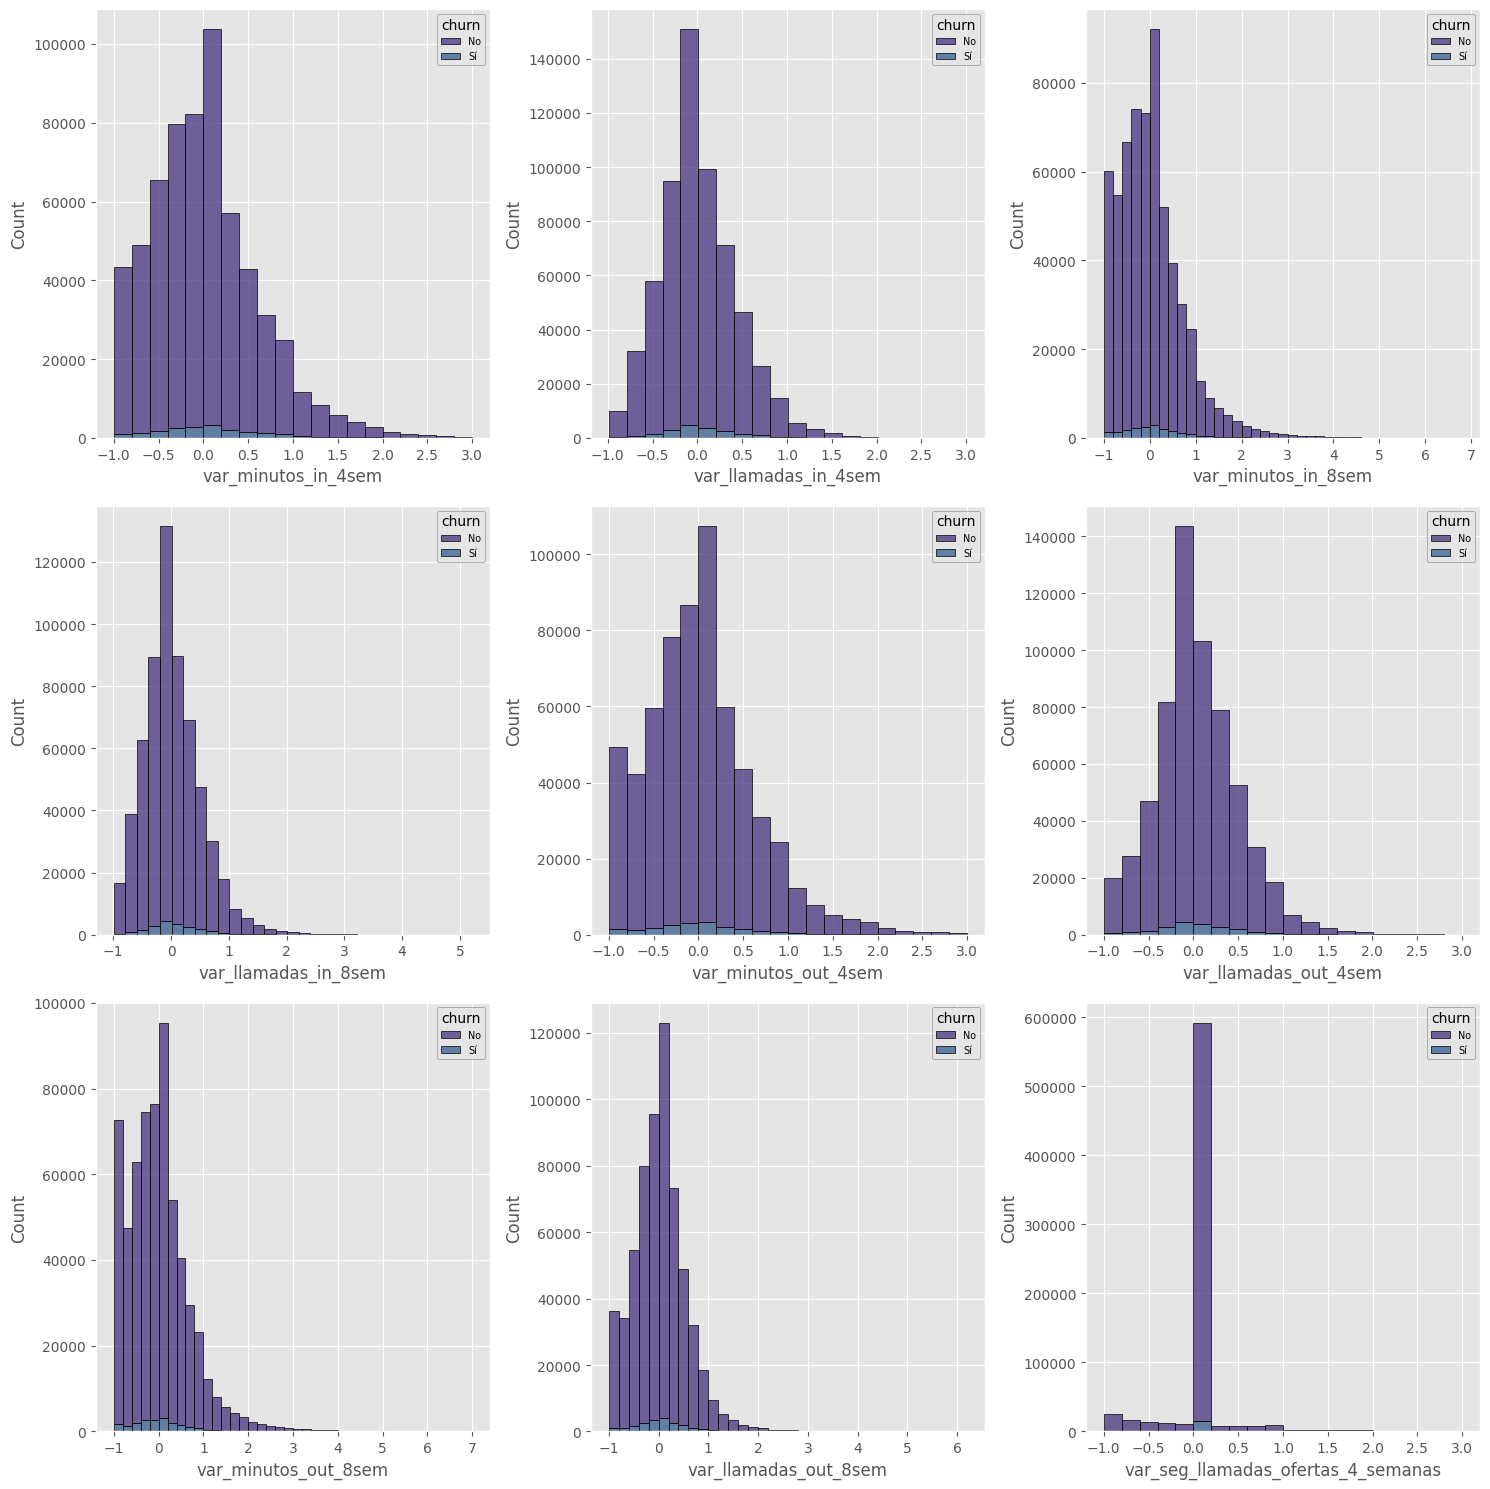

CPU times: user 8.43 s, sys: 268 ms, total: 8.7 s
Wall time: 8.7 s


In [150]:
%%time
# Variance features (9): range around 0 that can take negative values, upper limit less than 10
# Original data and not log10 y_axis transformation, see y_logscale parameter
vari_features = list(churn_df.columns[churn_df.columns.str.contains("var_")] ) + ["churn"]

plot = distrib_plots_seaborn(churn_df.reset_index(drop = True).loc[:, vari_features],
                             cat = 'churn',
                             stat = "count",
                             cols = 3,
                             binwidth = 0.2,
                             kde = False, # High runtime
                             y_logscale = False,
                             figsize = (15, 15) # height and width
)

#### Mean percent features

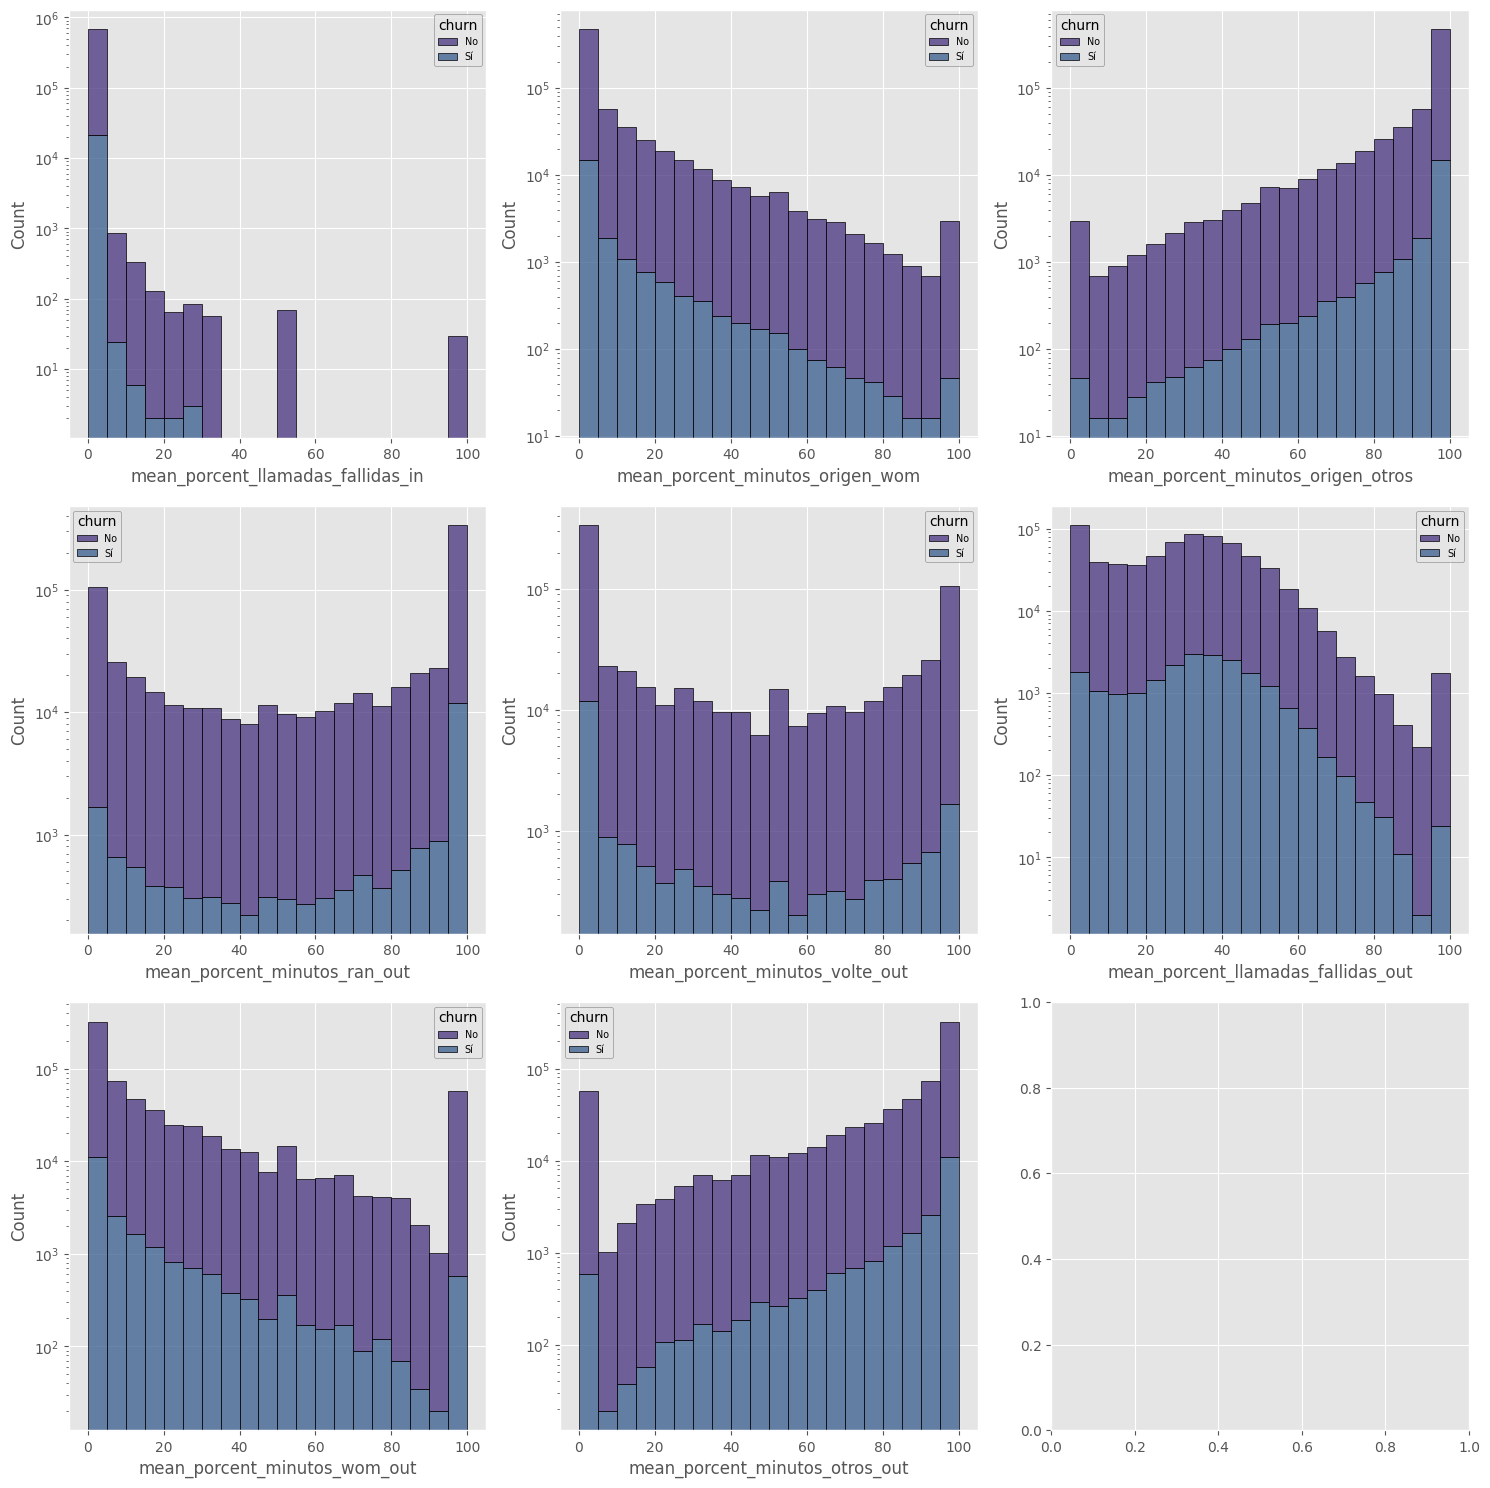

CPU times: user 7.87 s, sys: 379 ms, total: 8.25 s
Wall time: 8.06 s


In [202]:
%%time
# mean percent features (8): bottom limit = 0, upper limit = 100
# Original data and log10 y_axis transformation
mean_perc_features = list(churn_df.columns[churn_df.columns.str.contains("mean_porcent_")]) + ["churn"]

plot = distrib_plots_seaborn(churn_df.reset_index(drop = True).loc[:, mean_perc_features],
                             cat = 'churn',
                             stat = "count",
                             cols = 3,
                             binwidth = 5,
                             kde = False,
                             y_logscale = True,
                             figsize = (15, 15) # height and width
)

#### Count features

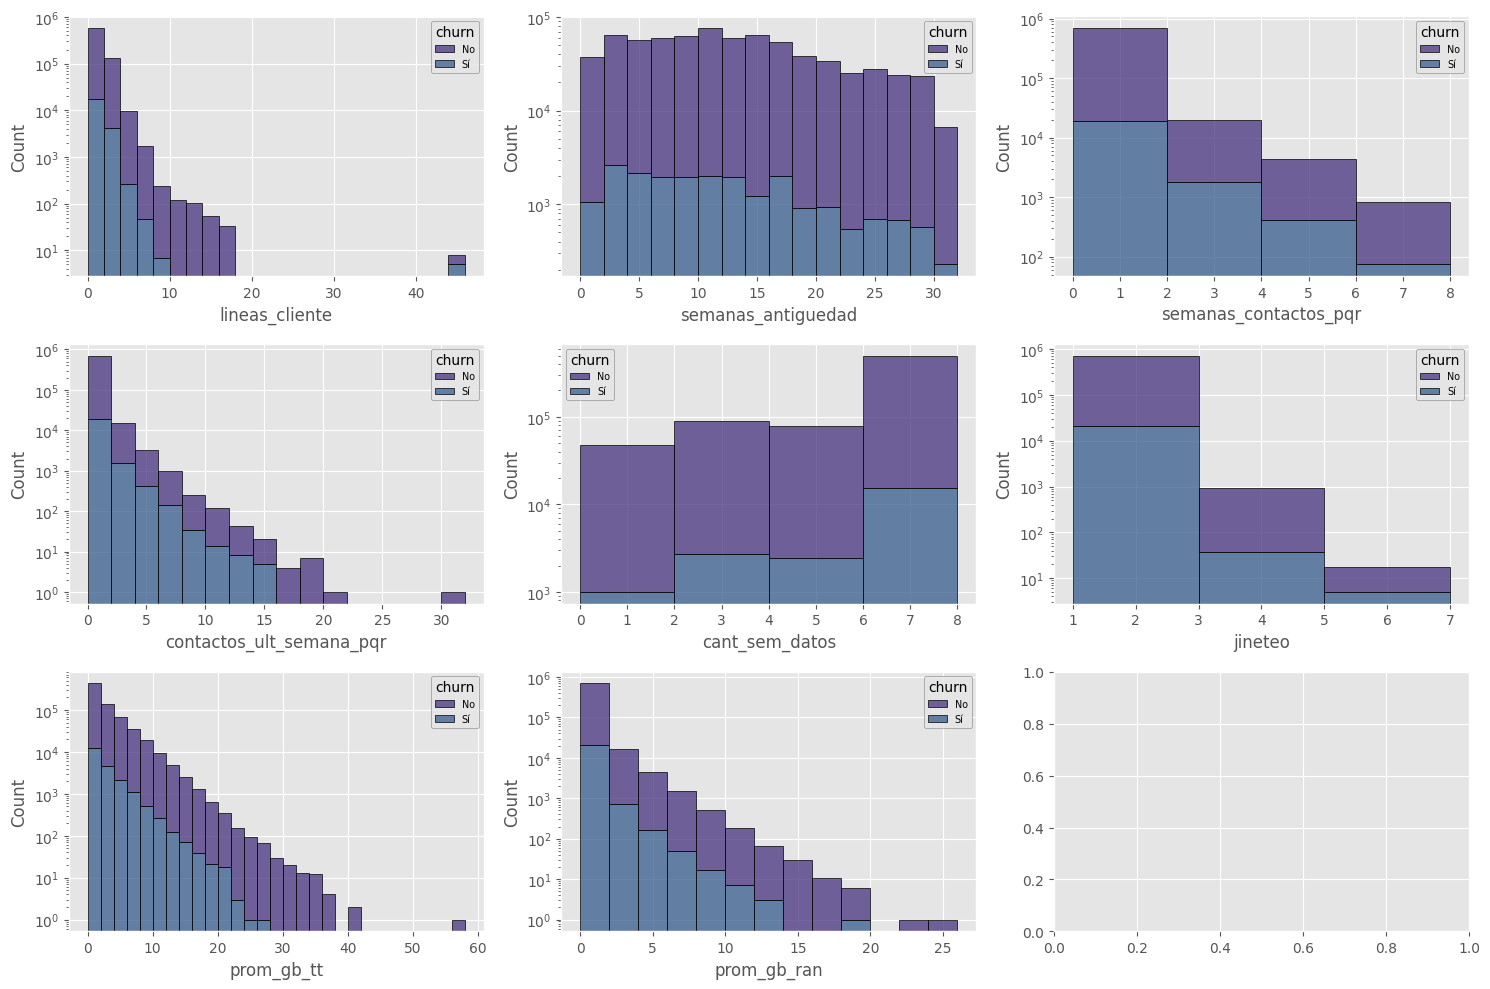

CPU times: user 12 s, sys: 211 ms, total: 12.3 s
Wall time: 12.6 s


In [158]:
%%time
# Count features (8): countings, bottom limit = 0, upper limit <= 50
# Original data and log10 y_axis transformation
count_features = ["lineas_cliente", "semanas_antiguedad", "semanas_contactos_pqr", "contactos_ult_semana_pqr",
                  "cant_sem_datos", "jineteo", "prom_gb_tt", "prom_gb_ran", "churn"]

plot = distrib_plots_seaborn(churn_df.reset_index(drop = True).loc[:, count_features],
                             #cat = 'churn',
                             stat = "count",
                             cols = 3,
                             binwidth = 2,
                             kde = False,
                             y_logscale = True,
                             figsize = (15, 10) # height and width
)

#### Another features

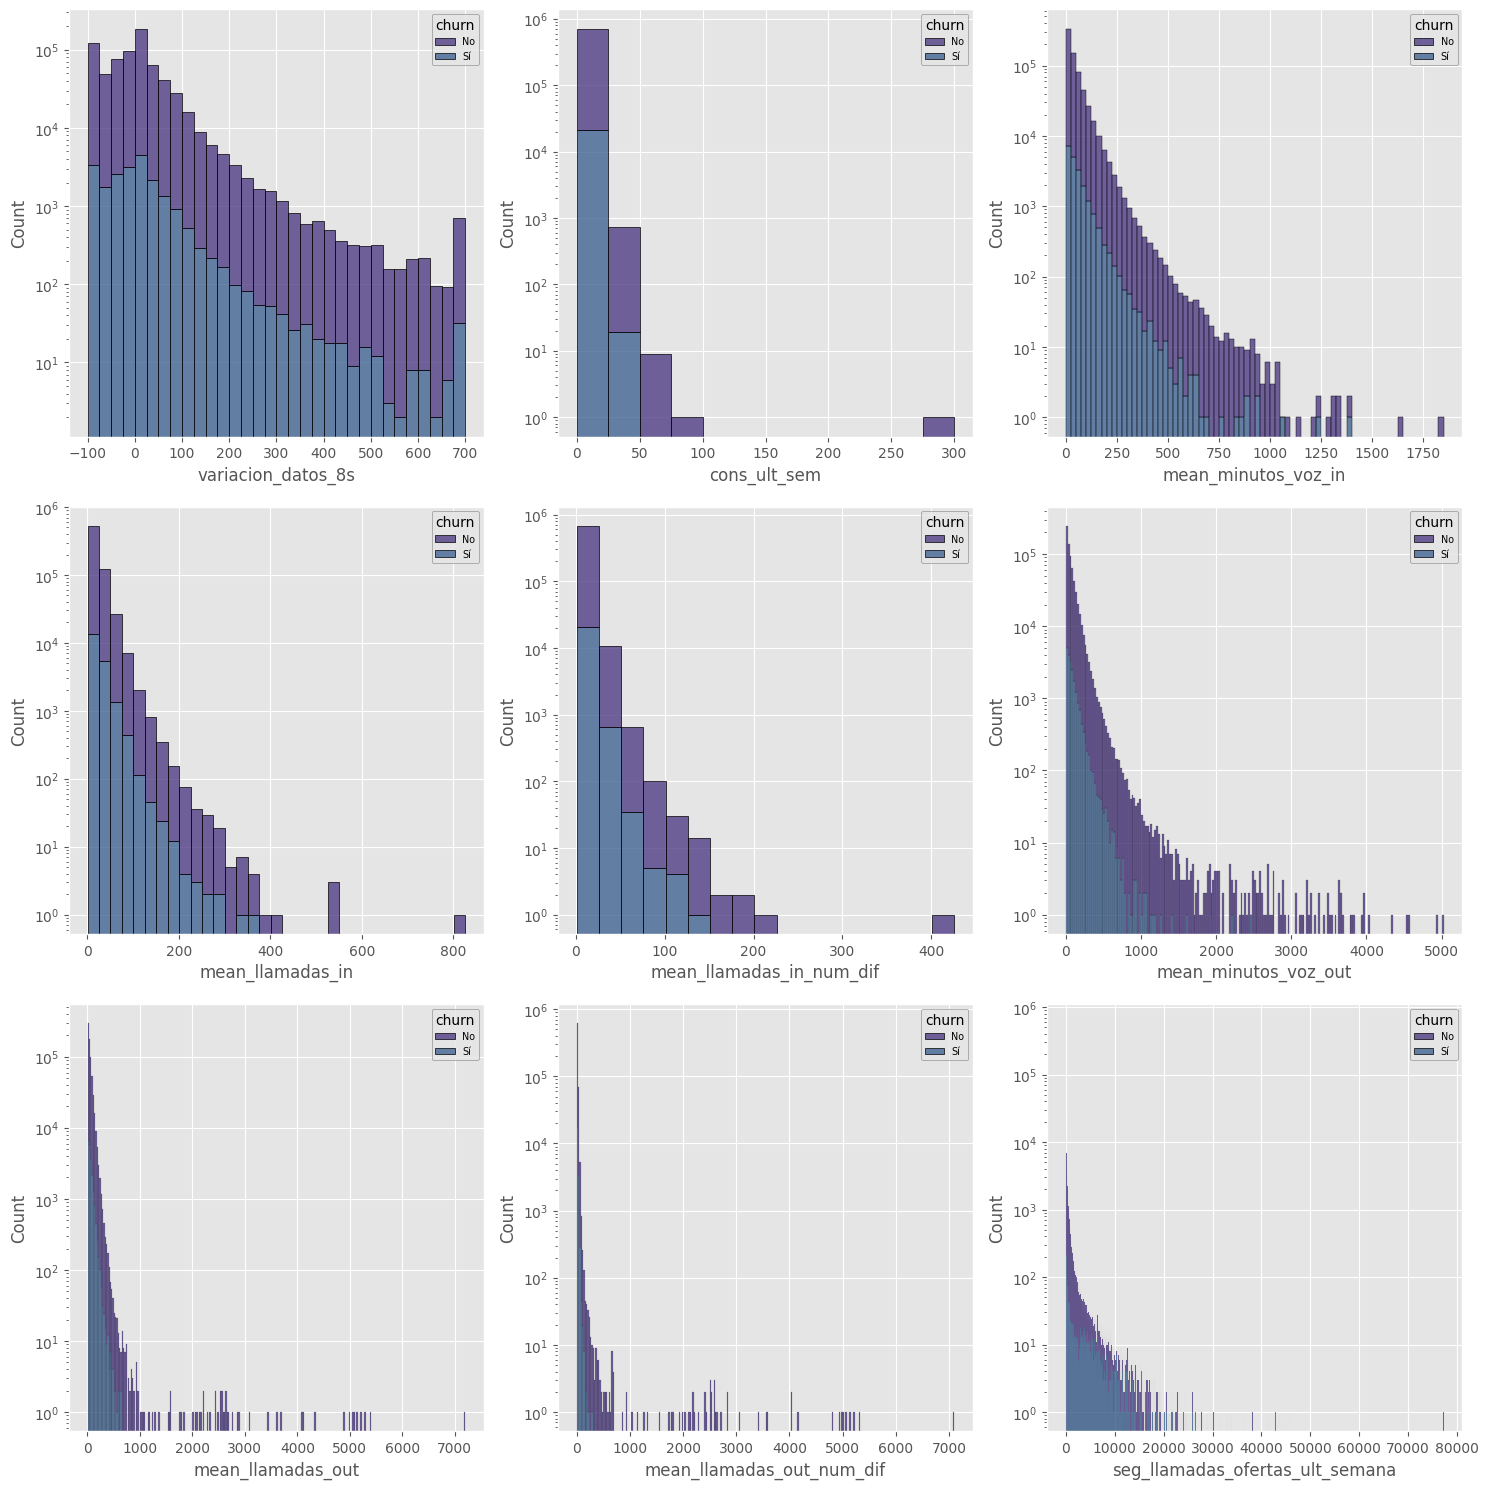

CPU times: user 37.1 s, sys: 511 ms, total: 37.6 s
Wall time: 37.7 s


In [243]:
%%time
# Already plots features
binary_features = ["contrafico", "continuidad_traf", "porc_descuento_activo", "prom_%_propia"]

first_features = list(vari_features) + list(mean_perc_features) + list(count_features) + list(binary_features)

last_features = list(churn_df.columns[~churn_df.columns.isin(first_features)]) + ["churn"]

plot = distrib_plots_seaborn(churn_df.reset_index(drop = True).loc[:, last_features],
                             cat = 'churn',
                             stat = "count",
                             cols = 3,
                             binwidth = 25,
                             kde = False,
                             y_logscale = True,
                             figsize = (15, 15) # height and width
)

### 2.4 - Categorical distributions

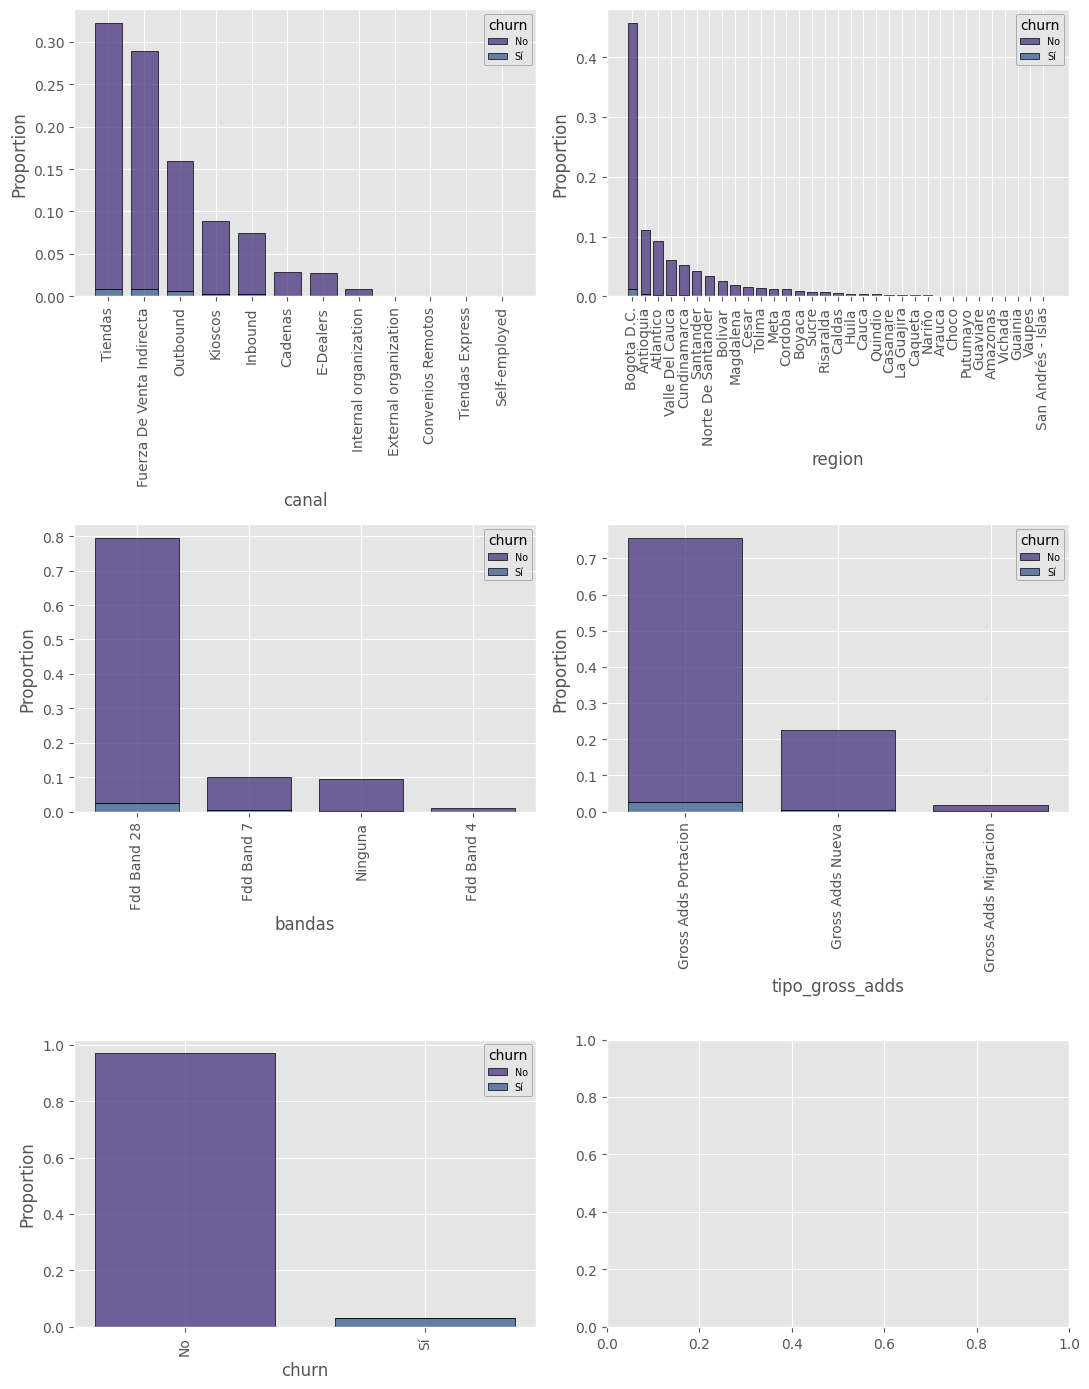

CPU times: user 5.08 s, sys: 241 ms, total: 5.32 s
Wall time: 5.14 s


In [ ]:
%%time
sns.set_palette(palette = "viridis") # Viridis pallete
barplots_seaborn(churn_df.reset_index(drop = True),
                 cat = "churn",
                 stat = "proportion",
                 cols = 2,
                 figsize = (11, 14) # height -> and width |
)

### 2.5 - Outliers detection

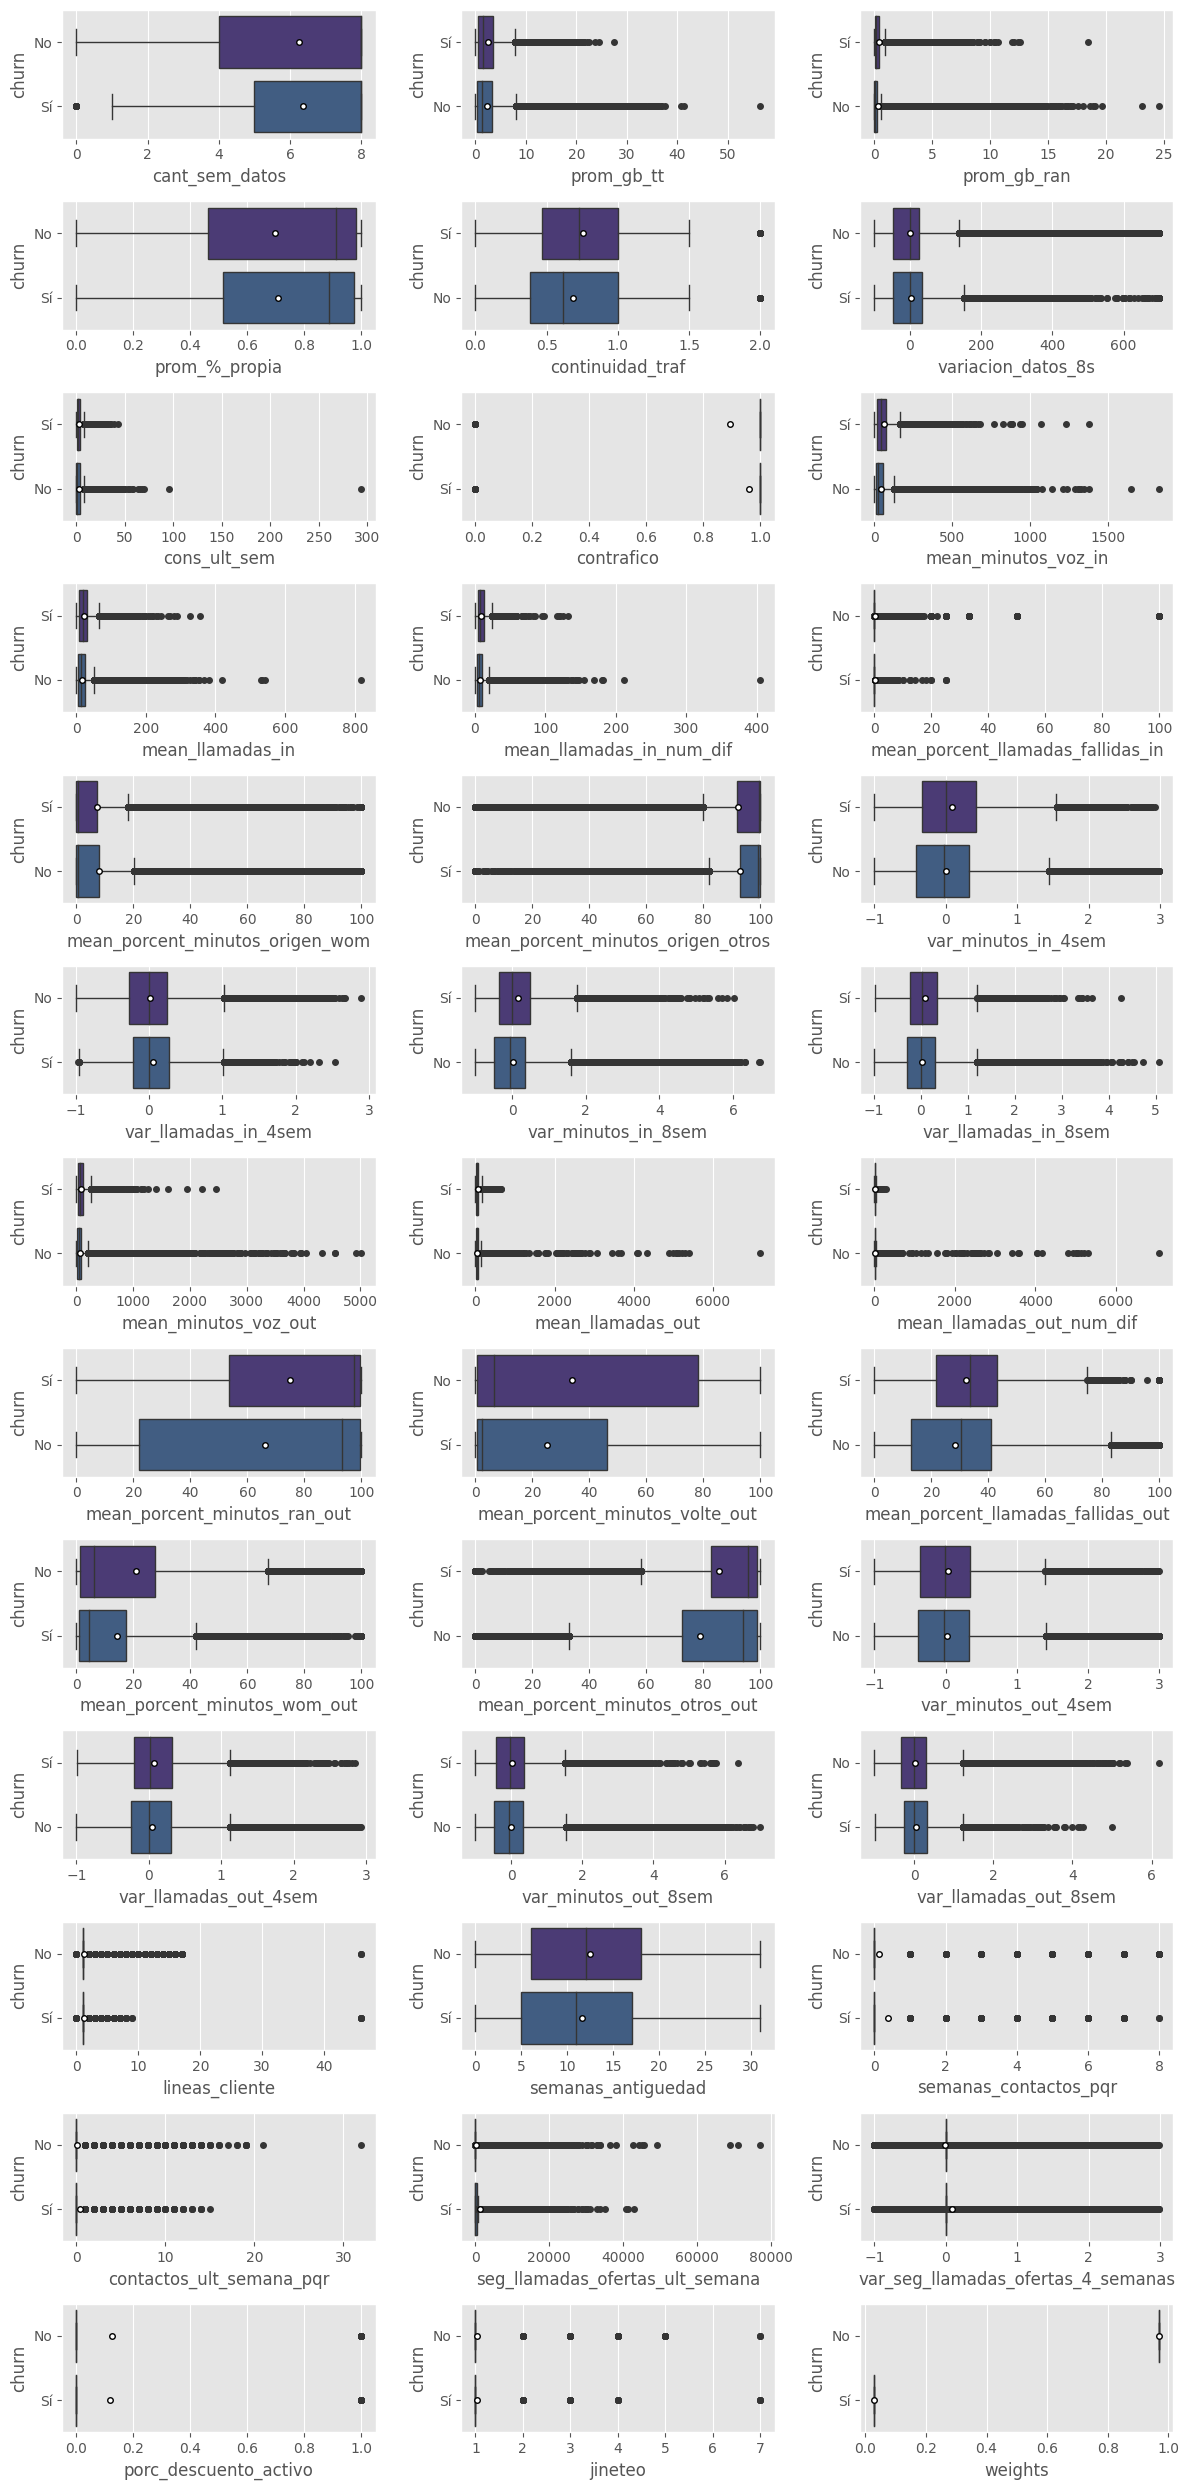

CPU times: user 12.7 s, sys: 254 ms, total: 12.9 s
Wall time: 13.6 s


In [213]:
%%time
boxplots_seaborn(churn_df,
                 cat = "churn",
                 # hue = "churn",
                 cols = 3,
                 figsize = (12, 25)
)

In [215]:
# Outliers detection using Empirical Cumulative Distribution Functions (ECOD)
outliers_detection(churn_df,
                   method = 'ECOD')

58839 outliers detected base on numerical data and ECOD algorithm.
outliers DataFrame was created.


        cant_sem_datos  prom_gb_tt  prom_gb_ran  prom_%_propia  continuidad_traf  variacion_datos_8s  cons_ult_sem  contrafico  mean_minutos_voz_in  mean_llamadas_in  mean_llamadas_in_num_dif  mean_porcent_llamadas_fallidas_in  mean_porcent_minutos_origen_wom  mean_porcent_minutos_origen_otros  var_minutos_in_4sem  var_llamadas_in_4sem  var_minutos_in_8sem  var_llamadas_in_8sem  mean_minutos_voz_out  mean_llamadas_out  mean_llamadas_out_num_dif  mean_porcent_minutos_ran_out  mean_porcent_minutos_volte_out  mean_porcent_llamadas_fallidas_out  mean_porcent_minutos_wom_out  mean_porcent_minutos_otros_out  var_minutos_out_4sem  var_llamadas_out_4sem  var_minutos_out_8sem  var_llamadas_out_8sem  lineas_cliente  semanas_antiguedad  semanas_contactos_pqr  contactos_ult_semana_pqr  seg_llamadas_ofertas_ult_semana  var_seg_llamadas_ofertas_4_semanas  porc_descuento_activo  jineteo  weights  is_o

### 2.6 Multiple Correspondence Analysis

In [217]:
# Variables to perform MCA
categorical_eda(churn_df,
                levels = 12)

MCA is used to analyze a set of observations described by a set of nominal variables.


canal, levels =  12 , ['Outbound', 'Tiendas', 'Inbound', 'Kioscos', 'E-Dealers', 'Internal organization', 'Fuerza De Venta Indirecta', 'Cadenas', 'Tiendas Express', 'External organization', 'Convenios Remotos', 'Self-employed']
region, levels =  33 , ['Bogota D.C.', 'Santander', 'Antioquia', 'Cundinamarca', 'Quindio', 'Valle Del Cauca', 'Arauca', 'Bolivar', 'Atlantico', 'Tolima', 'Huila', 'Meta', 'Putumayo', 'Boyaca', 'Caldas', 'Cordoba', 'Nariño', 'Magdalena', 'Risaralda', 'Cauca', 'La Guajira', 'Amazonas', 'Norte De Santander', 'Choco', 'Caqueta', 'Cesar', 'Sucre', 'Guaviare', 'Vaupes', 'Guainia']
bandas, levels =  4 , ['Fdd Band 28', 'Ninguna', 'Fdd Band 7', 'Fdd Band 4']
tipo_gross_adds, levels =  3 , ['Gross Adds Migracion', 'Gross Adds Nueva', 'Gross Adds Portacion']
churn, levels =  2 , ['No', 'Sí']


Variables to performance MCA:  ['canal', 'bandas', 'tipo_gross_adds', 'churn']


|    |   component |   eigenvalue |   % of variance |   % of variance (cumulative) |
|---:|------------:|-------------:|----------------:|-----------------------------:|
|  0 |           0 |        0.369 |            8.69 |                         8.69 |
|  1 |           1 |        0.308 |            7.24 |                        15.93 |
|  2 |           2 |        0.27  |            6.34 |                        22.27 |
|  3 |           3 |        0.252 |            5.93 |                        28.19 |
|  4 |           4 |        0.251 |            5.91 |                        34.11 |
|  5 |           5 |        0.251 |            5.9  |                        40.01 |
|  6 |           6 |        0.25  |            5.88 |                        45.89 |
|  7 |           7 |        0.25  |            5.88 |                        51.77 |
|  8 |           8 |        0.25  |            5.88 |                        57.65 |
|  9 |           9 |        0.25  |            5.88 |            

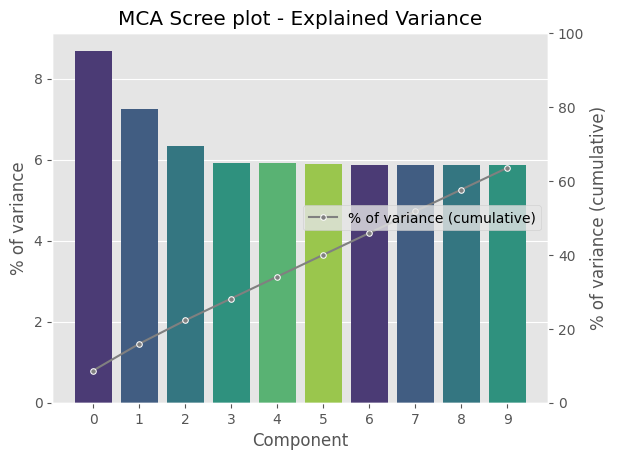

In [218]:
# Components to retain in MCA:
scree_plot_mca(churn_df)

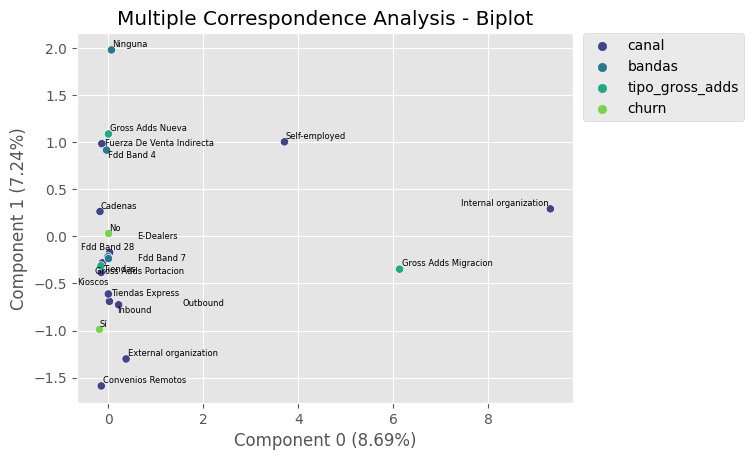

In [219]:
# Biplot for MCA
sns.set_palette(palette = "viridis") # Viridis pallete
vars_mca.remove("estado_civil")
biplot_mca(churn_df)

### 2.6 - Missing values

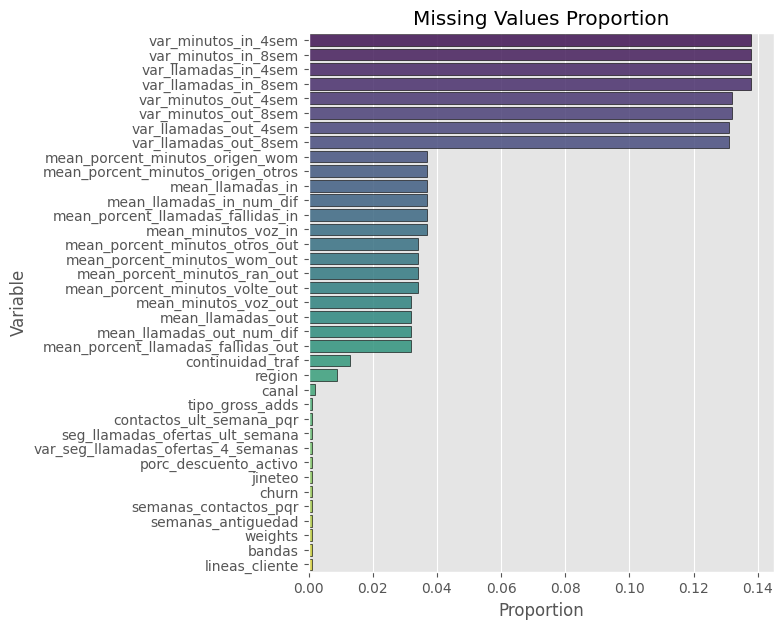

                              variable     dtype  missing_values  proportion_missing
0                  var_minutos_in_4sem   float32           98376               0.138
1                  var_minutos_in_8sem   float32           98372               0.138
2                 var_llamadas_in_4sem   float32           98362               0.138
3                 var_llamadas_in_8sem   float32           98362               0.138
4                 var_minutos_out_4sem   float32           94610               0.132
5                 var_minutos_out_8sem   float32           94436               0.132
6                var_llamadas_out_4sem   float32           93521               0.131
7                var_llamadas_out_8sem   float32           93521               0.131
8      mean_porcent_minutos_origen_wom   float32           26604               0.037
9    mean_porcent_minutos_origen_otros   float32           26604               0.037
10                    mean_llamadas_in   float32           26574 

In [232]:
# Missing values Data set 1:
plt.figure(figsize = (6, 7))
sns.set_palette(palette = "viridis") # Viridis pallete
missing_plot_seaborn(churn_df)

<Axes: >

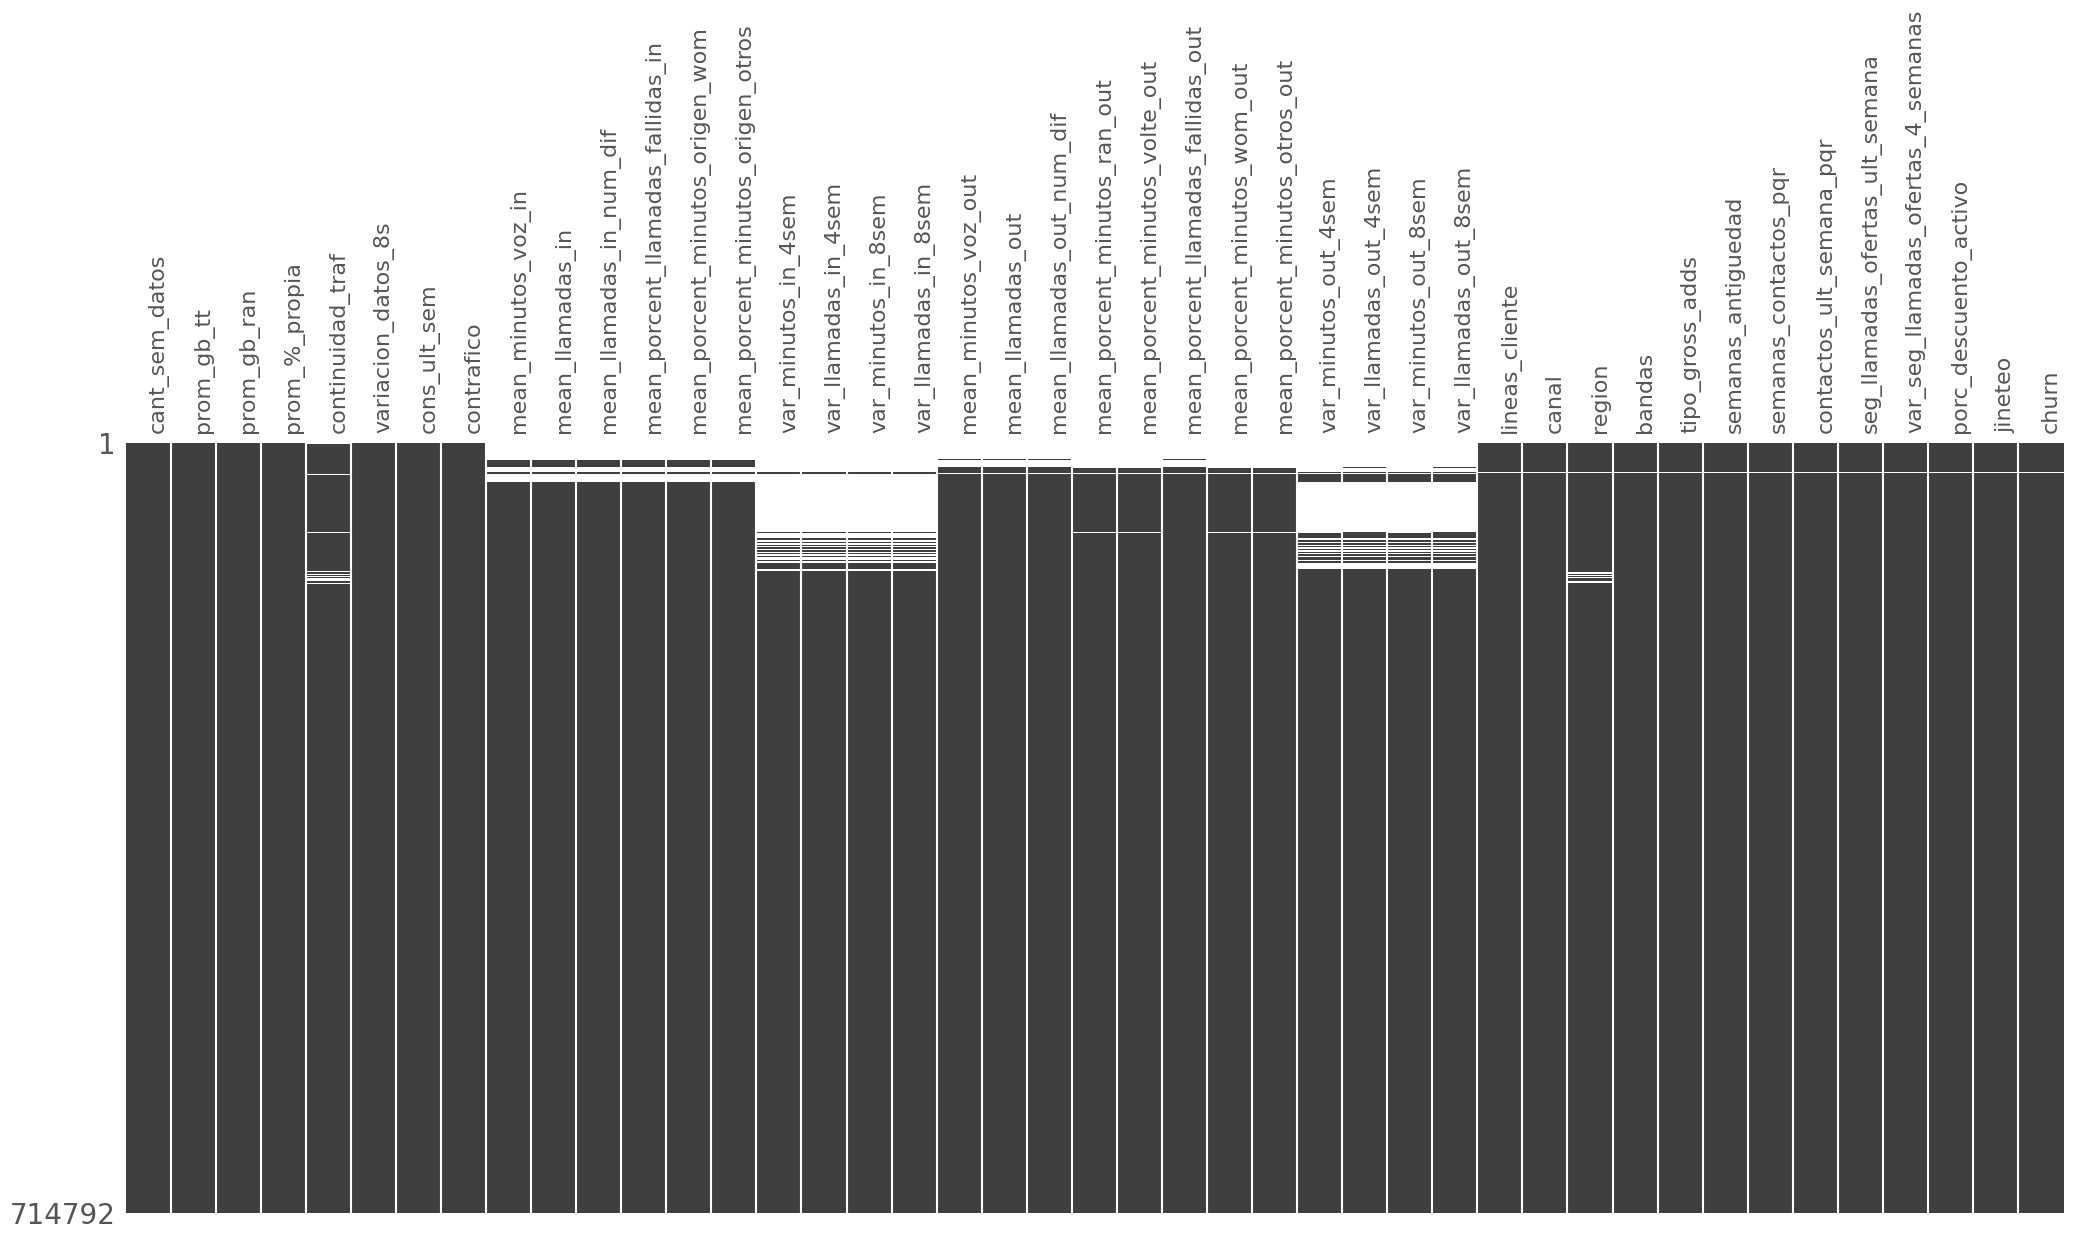

In [244]:
# Pick out patterns in data completion.
msno.matrix(churn_df,
            sparkline =  False,
            sort = 'ascending',
            label_rotation = 90)

Text(0.5, 1.0, 'Nullity correlation ranges from -1 (if one variable appears, the other definitely does not) \n to 0 (variables appearing or not appearing have no effect on one another) \n to 1 (if one variable appears, the other definitely also does). \n')

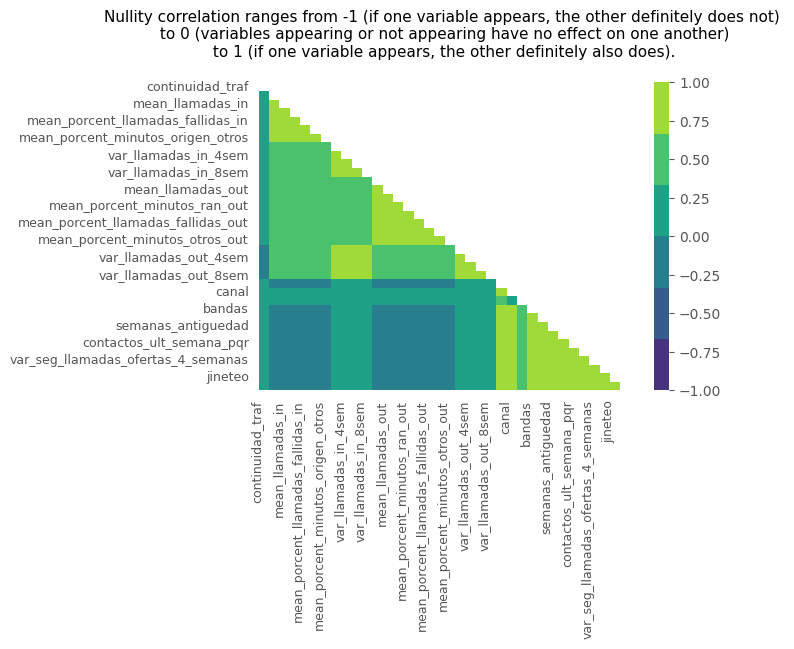

In [251]:
# Missing values correlation heatmap

# Measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another.
# Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 0 (variables appearing or not appearing have no effect on one another) to 1 (if one variable appears the other definitely also does).
msno.heatmap(churn_df,
             fontsize = 9,
             labels = False,
             label_rotation = 90,
             cmap = sns.color_palette(palette = "viridis"), # Viridis pallete
             figsize = (6, 4))

plt.title("Nullity correlation ranges from -1 (if one variable appears, the other definitely does not) \n to 0 (variables appearing or not appearing have no effect on one another) \n to 1 (if one variable appears, the other definitely also does). \n",
          fontdict = {'fontsize': 11})

<Axes: >

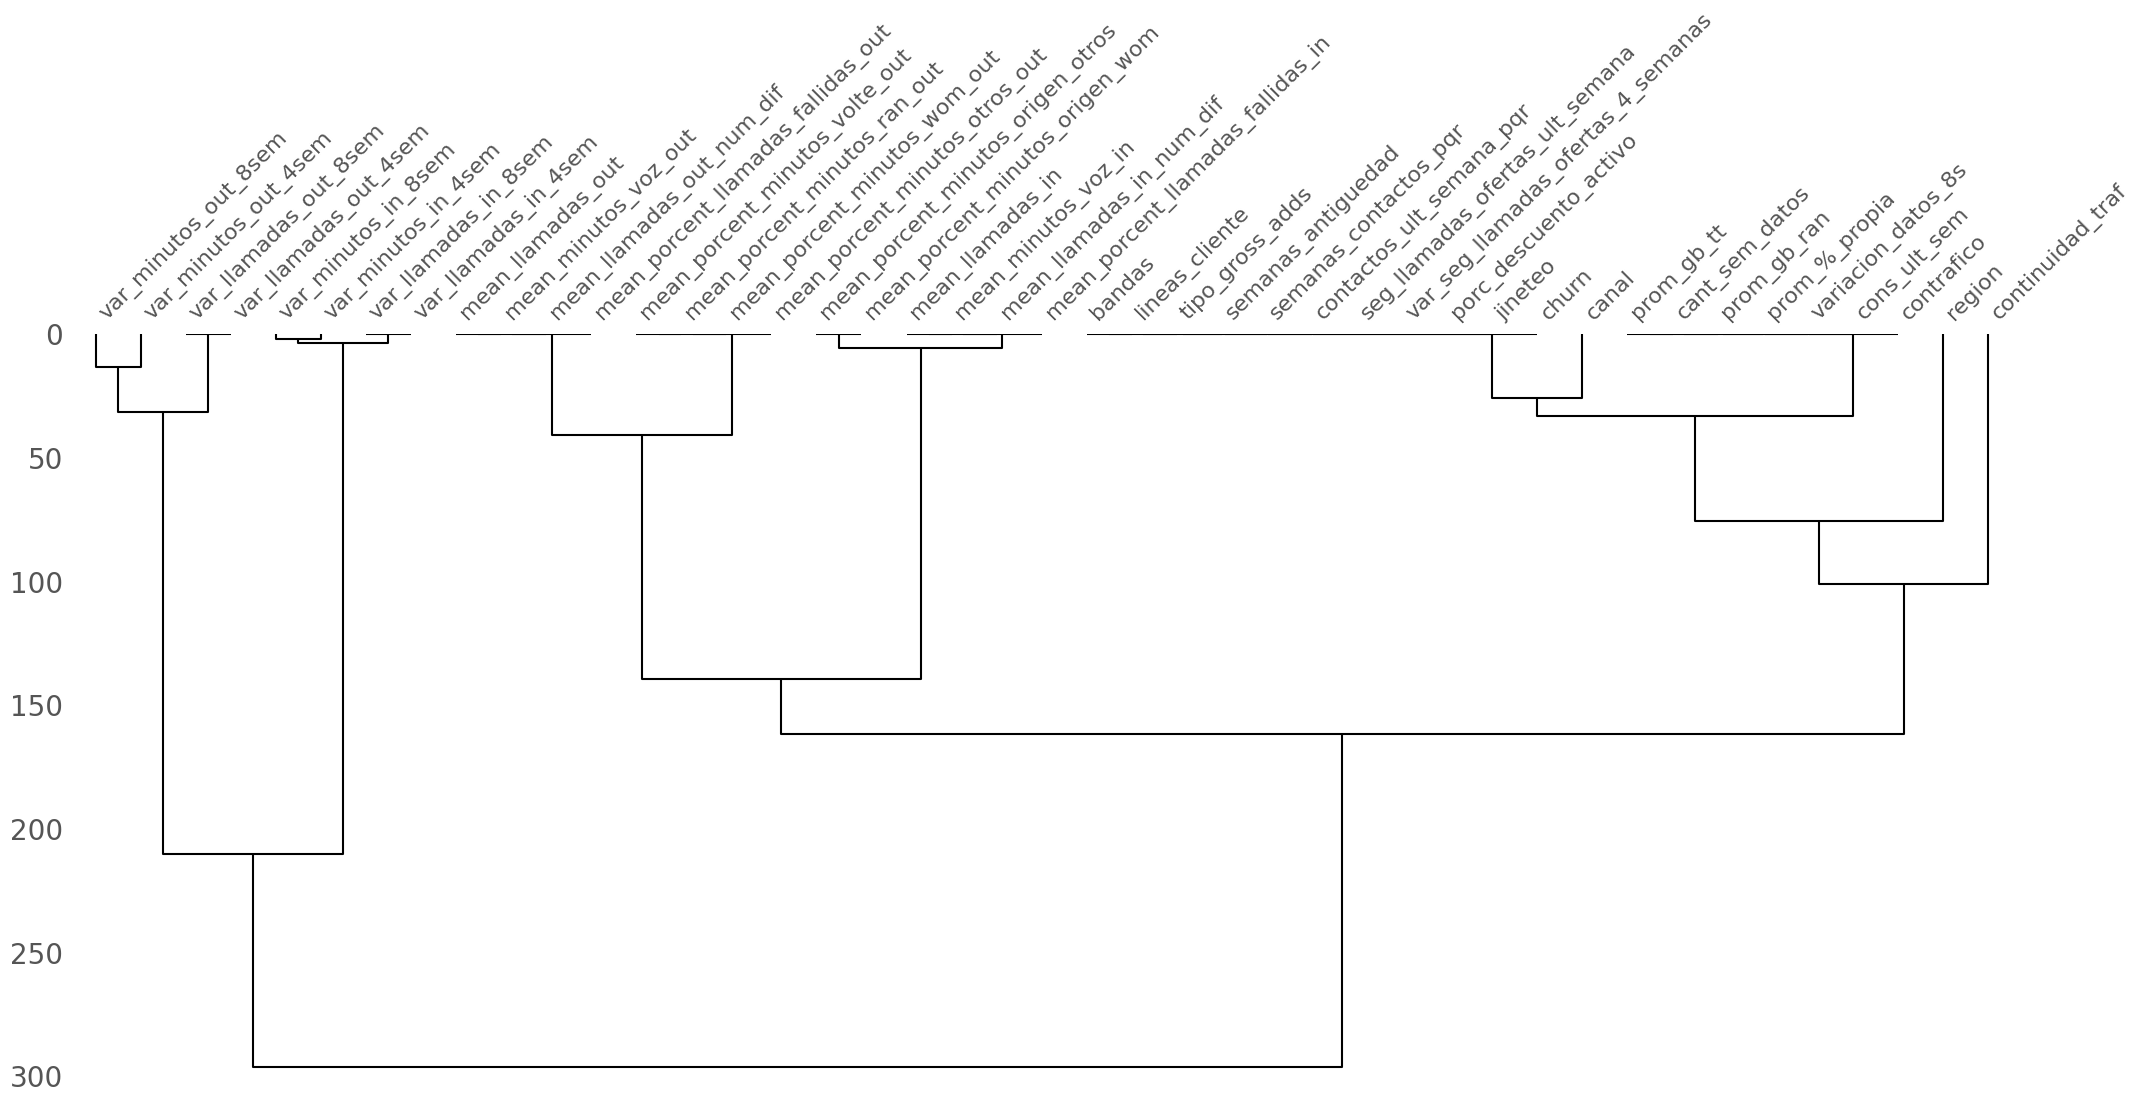

In [250]:
# Dendograma of missing values relations

# Allows a more fully correlate variable completion.
# Using a hierarchical clustering algorithm to bin variables against one another by their nullity correlation.
# More detalis: https://github.com/ResidentMario/missingno
msno.dendrogram(churn_df)